## Тестовое задание

**Цель:** Определить страну документа по изображениям паспорта/id

**Решение:** Изначально думал просто ocr-ом вытягивать mrz и доставать код страны, но получше прочитал условие тестового и решил использовать vlm.
  
**Идея подхода**
- Использовать энкодер для изображений ViT + энкодер SentenceTransformer (многоязычный).
- Страны представить **текстовыми прототипами**.
- Оценивать по acc@k, считал k-самых вероятных вариантов, среди всех рассматриваемых (потому что могут быть "похожие" страны, например Нидерланды/Бельгия).

**Что такое текстовые прототипы**: 

Закодированные промпты-описания к каждой стране, то есть:
- Кодируем промпты для каждой страны
- Переводим в одно пространство с картиноч эмбеддингами
- Усредняем и нормализуем
- В итоге получается усреднённый вектор из многих промптов-описаний одной страны

В конце считал косинусное расстояние изображ с прототипами.

**Плюсы подхода:**

- стабильность: не зависит от того, какую конкретную фразу подаем (усреднили много формулировок);
- масштабируемость: чтобы добавить страну, достаточно дописать её название и пересчитать прототип (без переобучения);
- обобщение на типы документов: добавил в промпты разные форматы - “ID/driver;
- скорость: на инференсе текстовый энкодер не нужен — только ViT + умножение на матрицу прототипов.


## Содержание
- [0. Установить зависимости](#install)
- [1. Конфиг](#setup)
- [2. Архитектура и прототипы](#method)
- [3. Обучение и валидация](#train)
- [4. Инференс](#eval)
- [5. Анализ ошибок](#errors)
- [6. Просмотреть вручную](#look)
- [7. Плюсы и минусы](#end)


## 0. Установить зависимости <a id='install'></a>

In [1]:
!pip -q install timm==1.0.7 sentence-transformers==3.0.1 torchmetrics==1.4.0.post0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.

## 1. Конфиг <a id='setup'></a>

In [8]:
import os, math, random, json
from dataclasses import dataclass
from typing import Dict, List, Tuple
from collections import Counter

import pandas as pd
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import timm
from timm.data import resolve_model_data_config, create_transform
from tqdm import tqdm

TRAIN_CSV = "/kaggle/input/testing/train_resolved.csv"
VAL_CSV   = "/kaggle/input/testing/val_resolved.csv"
OUT_DIR   = "/kaggle/working/ckpt_vlm"
os.makedirs(OUT_DIR, exist_ok=True)

ST_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
LOCAL_ST_PATH = None  # путь к локальным весам, если без интернета

EPOCHS = 10
BATCH_SIZE = 32
LR = 3e-4
BACKBONE = "vit_small_patch16_224"
GRAD_ACCUM_STEPS = 1  
CLIP_MAX_NORM = 1.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


## 2. Архитектура и прототипы <a id='method'></a>

**Текстовый энкодер** 

Использовал multilingual-MiniLM-L12-v2, заморозив веса

**Картиночный энкодер**

Использовал энкодер ViT (timm), привел в одно пространство эмбеддинги, добавил logit_scale для подбора soft_max

**Лосс**

Использовал лосс InfoNCE (как в оригинальном CLIP). 

**Пул названий стран**

Основная идея в том, чтобы для каждой страны собрать много текстовых формулировок (англ + локальные языки + разные типы документов)

In [9]:
# ---- пулл названий стран ----
ISO3_TO_NAME = {
    "USA":"United States","GBR":"United Kingdom","ESP":"Spain","FRA":"France","DEU":"Germany",
    "HUN":"Hungary","DOM":"Dominican Republic","BLR":"Republic of Belarus","EST":"Estonia",
    "NLD":"Netherlands","KGZ":"Kyrgyzstan",
    "ITA":"Italy","IRL":"Ireland","CAN":"Canada","AUS":"Australia","MEX":"Mexico","BRA":"Brazil",
    "ARG":"Argentina","CHL":"Chile","ZAF":"South Africa","IND":"India","CHN":"China","JPN":"Japan",
    "KOR":"South Korea","POL":"Poland","BEL":"Belgium","BGR":"Bulgaria","SVK":"Slovakia","SWE":"Sweden",
    "RUS":"Russia","UKR":"Ukraine","KAZ":"Kazakhstan","TUR":"Turkey","IDN":"Indonesia","MDA":"Moldova","UZB":"Uzbekistan"
}

LOCAL_ALIASES = {
    "ESP": ["España", "Reino de España"],
    "DEU": ["Deutschland", "Bundesrepublik Deutschland"],
    "FRA": ["France", "République française"],
    "IRL": ["Éire", "Ireland"],
    "ITA": ["Italia", "Repubblica Italiana"],
    "JPN": ["日本", "Japan"],
    "KOR": ["대한민국", "Republic of Korea"],
    "RUS": ["Россия", "Российская Федерация"],
    "UKR": ["Україна"],
    "KAZ": ["Қазақстан", "Kazakhstan", "Republic of Kazakhstan", "Республика Казахстан"],
    "KGZ": ["Кыргызстан", "Kyrgyzstan", "Kyrgyz Republic", "Кыргызская Республика"],
    "TUR": ["Türkiye", "Republic of Türkiye"],
    "MDA": ["Republica Moldova"],
    "UZB": ["O‘zbekiston", "Uzbekistan"],
    "SVK": ["Slovensko"],
    "SWE": ["Sverige"],
    "GBR": ["Britain","Great Britain","United Kingdom","UK"],
}

PROMPT_TEMPLATES = [
    "passport from {name} ({iso})",
    "document issued by {name} ({iso})",
    "identity document of {name} ({iso})",
    "ID card from {name} ({iso})",
    "driver license from {name} ({iso})",
    "voter card from {name} ({iso})",
    "travel document from {name} ({iso})",
    "документ, выданный {name} ({iso})",
    "паспорт {name} ({iso})",
]

def build_country_prompts(iso3_to_name: Dict[str,str]) -> Dict[str, List[str]]:
    prompts: Dict[str, List[str]] = {}
    for iso, en_name in iso3_to_name.items():
        names = {en_name}
        for alias in LOCAL_ALIASES.get(iso, []):
            names.add(alias)
        variants: List[str] = []
        for nm in names:
            for tmpl in PROMPT_TEMPLATES:
                variants.append(tmpl.format(name=nm, iso=iso))
        prompts[iso] = sorted(set(variants))
    return prompts

# ----------- текстовый энкодер -----------
from sentence_transformers import SentenceTransformer

class FrozenTextEncoder(nn.Module):
    def __init__(self, model_name: str = ST_MODEL_NAME, local_dir: str = LOCAL_ST_PATH):
        super().__init__()
        if local_dir and os.path.isdir(local_dir):
            self.model = SentenceTransformer(local_dir)
        else:
            self.model = SentenceTransformer(model_name)
        for p in self.model.parameters():
            p.requires_grad_(False)
        self.out_dim = self.model.get_sentence_embedding_dimension()

    @torch.no_grad()
    def encode(self, texts: List[str], device: torch.device) -> torch.Tensor:
        emb = self.model.encode(texts, convert_to_tensor=True, device=str(device), normalize_embeddings=False)
        return emb  # [N, D]

# ----------- vit энкодер  -----------
class CountryVLM(nn.Module):
    def __init__(self, backbone: str = BACKBONE, proj_dim: int = 512, txt_in_dim: int = 384):
        super().__init__()
        self.visual = timm.create_model(backbone, pretrained=True, num_classes=0, global_pool='avg')
        self.proj_img = nn.Linear(self.visual.num_features, proj_dim)
        self.proj_txt = nn.Linear(txt_in_dim, proj_dim)
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # trainable temperature

    def encode_image(self, x: torch.Tensor) -> torch.Tensor:
        z = self.visual(x)
        z = self.proj_img(z)
        z = F.normalize(z, dim=-1)
        return z

    def encode_text(self, txt_emb: torch.Tensor) -> torch.Tensor:
        z = self.proj_txt(txt_emb)
        z = F.normalize(z, dim=-1)
        return z

    def forward(self, img: torch.Tensor, txt_emb: torch.Tensor):
        return self.encode_image(img), self.encode_text(txt_emb)

def clip_loss(zi: torch.Tensor, zt: torch.Tensor, logit_scale: torch.Tensor) -> torch.Tensor:
    logits = logit_scale.exp() * zi @ zt.t()
    labels = torch.arange(zi.size(0), device=zi.device)
    return 0.5 * (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels))

@dataclass
class CountryPrototypes:
    iso2emb: Dict[str, torch.Tensor]  # iso -> [D]
    proj_dim: int


In [10]:
# прототипы, даталоадер
@torch.no_grad()
def compute_text_prototypes(text_encoder: FrozenTextEncoder,
                            model: CountryVLM,
                            prompts_by_iso: Dict[str, List[str]],
                            device: torch.device,
                            batch: int = 64) -> CountryPrototypes:
    iso2 = {}
    for iso, prompts in prompts_by_iso.items():
        all_vecs = []
        for i in range(0, len(prompts), batch):
            chunk = prompts[i:i+batch]
            t_raw = text_encoder.encode(chunk, device=device)  # [n, d_txt]
            t_proj = model.encode_text(t_raw)                  # [n, D]
            all_vecs.append(t_proj)
        mat = torch.cat(all_vecs, dim=0)                       # [M, D]
        centroid = F.normalize(mat.mean(dim=0), dim=0)         # [D]
        iso2[iso] = centroid.detach().cpu()
    return CountryPrototypes(iso2emb=iso2, proj_dim=list(iso2.values())[0].numel())

class CountryDataset(Dataset):
    def __init__(self, csv_path: str, transform):
        df = pd.read_csv(csv_path)
        assert {"path","iso3"}.issubset(df.columns), "path, iso3"
        self.paths = df["path"].astype(str).tolist()
        self.iso3  = df["iso3"].astype(str).tolist()
        self.tf = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.tf(img), self.iso3[i]

def build_transforms_for(model: CountryVLM):
    cfg = resolve_model_data_config(model.visual)
    tf_train = create_transform(**cfg, is_training=True)
    tf_eval  = create_transform(**cfg, is_training=False)
    return tf_train, tf_eval

def accuracy_top1_with_prototypes(zi: torch.Tensor, isos: List[str], prototypes: CountryPrototypes, device) -> int:
    correct = 0
    for b in range(zi.size(0)):
        best_iso, best_s = None, -1e9
        for iso, ce in prototypes.iso2emb.items():
            s = float(torch.dot(zi[b], ce.to(device)))
            if s > best_s:
                best_s, best_iso = s, iso
        correct += int(best_iso == isos[b])
    return correct


## 3. Обучение и валидация <a id='train'></a>
- Использовал AdamW
- Добавил аугментации - resize/кроп
- На валидации считаю тот же лосс, но беру фиксированный промпт
- Метрика - acc@1, топ-1 по кос расст к прототипам

In [11]:
# обучение + валидация
def train_and_validate(train_csv=TRAIN_CSV, val_csv=VAL_CSV,
                       epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR,
                       out_dir=OUT_DIR, backbone=BACKBONE, grad_accum=GRAD_ACCUM_STEPS):
    txt_enc = FrozenTextEncoder()
    model = CountryVLM(backbone=backbone, txt_in_dim=txt_enc.out_dim).to(DEVICE)

    tf_train, tf_eval = build_transforms_for(model)
    train_ds = CountryDataset(train_csv, tf_train)
    val_ds   = CountryDataset(val_csv,   tf_eval)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=2, pin_memory=True)

    prompts_by_iso = build_country_prompts(ISO3_TO_NAME)

    backbone_params, head_params = [], []
    for n,p in model.named_parameters():
        if not p.requires_grad: continue
        (backbone_params if n.startswith("visual.") else head_params).append(p)
    opt = torch.optim.AdamW([
        {"params": backbone_params, "lr": lr*0.1},
        {"params": head_params,     "lr": lr},
    ], weight_decay=0.05)

    steps_per_epoch = len(train_loader)
    warmup = max(100, int(0.5 * steps_per_epoch))
    total_steps = epochs * steps_per_epoch
    def lr_lambda(step):
        if step < warmup: return step / max(1, warmup)
        t = (step - warmup) / max(1, total_steps - warmup)
        return 0.5 * (1 + math.cos(math.pi * t))
    sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
    best_acc1 = -1.0

    for epoch in range(1, epochs+1):
        # ---- TRAIN
        model.train()
        pbar = tqdm(train_loader, desc=f"epoch {epoch}/{epochs}")
        avg_loss = 0.0
        opt.zero_grad(set_to_none=True)

        for step, (imgs, isos) in enumerate(pbar):
            imgs = imgs.to(DEVICE)

            texts = [random.choice(prompts_by_iso.get(iso, [ISO3_TO_NAME.get(iso, iso)])) for iso in isos]
            with torch.no_grad():
                txt_raw = txt_enc.encode(texts, device=DEVICE)

            with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
                zi, zt = model(imgs, txt_raw)
                loss = clip_loss(zi, zt, model.logit_scale) / grad_accum

            scaler.scale(loss).backward()
            if (step+1) % grad_accum == 0:
                scaler.unscale_(opt)
                if CLIP_MAX_NORM:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_MAX_NORM)
                scaler.step(opt)
                scaler.update()
                sched.step()
                opt.zero_grad(set_to_none=True)

                with torch.no_grad():
                    model.logit_scale.clamp_(math.log(1/0.2), math.log(1/0.01))

            avg_loss = 0.98*avg_loss + 0.02*loss.item()*grad_accum if avg_loss>0 else loss.item()*grad_accum
            pbar.set_postfix(loss=f"{avg_loss:.4f}", T=math.exp(model.logit_scale.item()))

        # чекпойнт по эпохе
        torch.save({"model": model.state_dict(), "epoch": epoch},
                   os.path.join(out_dir, f"vlm_ep{epoch}.pt"))

        # ---- VALIDATION (acc@1 по прототипам + val_loss)
        model.eval()
        with torch.no_grad():
            prototypes = compute_text_prototypes(txt_enc, model, prompts_by_iso, device=DEVICE)

        total, correct, tot_loss = 0, 0, 0.0
        for imgs, isos in tqdm(val_loader, desc="val"):
            imgs = imgs.to(DEVICE)
            texts = [prompts_by_iso[iso][0] for iso in isos]  # фиксированный шаблон
            txt_raw = txt_enc.encode(texts, device=DEVICE)
            zi, zt = model(imgs, txt_raw)
            tot_loss += clip_loss(zi, zt, model.logit_scale).item() * imgs.size(0)
            correct += accuracy_top1_with_prototypes(zi, isos, prototypes, DEVICE)
            total += imgs.size(0)

        val_loss = tot_loss / max(1,total)
        acc1 = 100.0 * correct / max(1,total)
        print(f"[VAL] epoch {epoch}: val_loss={val_loss:.4f}  acc@1={acc1:.2f}%")

        # сохранить лучший по acc@1
        if acc1 > best_acc1:
            best_acc1 = acc1
            torch.save({"model": model.state_dict(), "acc1": acc1, "epoch": epoch},
                       os.path.join(out_dir, "best.pt"))
            # и прототипы к нему
            torch.save({"iso2emb": {k: v for k, v in prototypes.iso2emb.items()}},
                       os.path.join(out_dir, "country_prototypes.pt"))

    print("Best acc@1:", best_acc1)
    return os.path.join(out_dir, "best.pt")


In [12]:
best_ckpt_path = train_and_validate()
best_ckpt_path


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

/tmp/ipykernel_36/1924449587.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
epoch 1/10:   0%|          | 0/68 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_36/1924449587.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
epoch 1/10:   1%|▏         | 1/68 [00:03<04:24,  3.95s/it, T=14.3, loss=3.4139]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:   3%|▎         | 2/68 [00:04<01:55,  1.75s/it, T=14.3, loss=3.4153]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:   4%|▍         | 3/68 [00:05<01:33,  1.43s/it, T=14.3, loss=3.4167]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:   6%|▌         | 4/68 [00:05<01:01,  1.05it/s, T=14.3, loss=3.4208]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:   7%|▋         | 5/68 [00:07<01:15,  1.20s/it, T=14.3, loss=3.4224]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:   9%|▉         | 6/68 [00:07<00:53,  1.15it/s, T=14.3, loss=3.4239]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  10%|█         | 7/68 [00:09<01:13,  1.21s/it, T=14.3, loss=3.4253]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  12%|█▏        | 8/68 [00:09<00:53,  1.12it/s, T=14.3, loss=3.4256]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  13%|█▎        | 9/68 [00:11<01:11,  1.21s/it, T=14.3, loss=3.4265]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  15%|█▍        | 10/68 [00:11<00:52,  1.11it/s, T=14.3, loss=3.4260]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  16%|█▌        | 11/68 [00:13<01:05,  1.14s/it, T=14.3, loss=3.4270]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  18%|█▊        | 12/68 [00:13<00:48,  1.17it/s, T=14.3, loss=3.4271]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  19%|█▉        | 13/68 [00:14<00:57,  1.05s/it, T=14.3, loss=3.4259]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  21%|██        | 14/68 [00:15<00:43,  1.25it/s, T=14.3, loss=3.4254]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  22%|██▏       | 15/68 [00:16<00:56,  1.06s/it, T=14.3, loss=3.4240]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  24%|██▎       | 16/68 [00:17<00:41,  1.24it/s, T=14.3, loss=3.4232]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  25%|██▌       | 17/68 [00:18<00:55,  1.08s/it, T=14.3, loss=3.4222]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  26%|██▋       | 18/68 [00:18<00:40,  1.22it/s, T=14.3, loss=3.4213]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  28%|██▊       | 19/68 [00:20<00:52,  1.07s/it, T=14.3, loss=3.4211]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  29%|██▉       | 20/68 [00:20<00:38,  1.24it/s, T=14.3, loss=3.4202]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  31%|███       | 21/68 [00:22<00:47,  1.00s/it, T=14.3, loss=3.4187]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  32%|███▏      | 22/68 [00:22<00:35,  1.31it/s, T=14.3, loss=3.4174]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  34%|███▍      | 23/68 [00:24<00:46,  1.03s/it, T=14.3, loss=3.4145]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  35%|███▌      | 24/68 [00:24<00:34,  1.28it/s, T=14.3, loss=3.4102]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  37%|███▋      | 25/68 [00:26<00:45,  1.06s/it, T=14.3, loss=3.4068]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  38%|███▊      | 26/68 [00:26<00:33,  1.24it/s, T=14.3, loss=3.4032]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  40%|███▉      | 27/68 [00:27<00:44,  1.08s/it, T=14.3, loss=3.3996]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  41%|████      | 28/68 [00:28<00:32,  1.22it/s, T=14.3, loss=3.3935]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  43%|████▎     | 29/68 [00:29<00:41,  1.06s/it, T=14.3, loss=3.3890]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  44%|████▍     | 30/68 [00:30<00:30,  1.24it/s, T=14.3, loss=3.3840]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  46%|████▌     | 31/68 [00:31<00:40,  1.09s/it, T=14.3, loss=3.3755]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  47%|████▋     | 32/68 [00:31<00:29,  1.20it/s, T=14.3, loss=3.3677]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  49%|████▊     | 33/68 [00:33<00:37,  1.07s/it, T=14.3, loss=3.3607]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  50%|█████     | 34/68 [00:33<00:27,  1.23it/s, T=14.3, loss=3.3527]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  51%|█████▏    | 35/68 [00:35<00:33,  1.02s/it, T=14.3, loss=3.3446]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  53%|█████▎    | 36/68 [00:35<00:24,  1.29it/s, T=14.3, loss=3.3365]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  54%|█████▍    | 37/68 [00:37<00:32,  1.05s/it, T=14.3, loss=3.3280]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  56%|█████▌    | 38/68 [00:37<00:23,  1.26it/s, T=14.3, loss=3.3174]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  57%|█████▋    | 39/68 [00:38<00:28,  1.01it/s, T=14.3, loss=3.3091]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  59%|█████▉    | 40/68 [00:39<00:21,  1.32it/s, T=14.3, loss=3.2977]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  60%|██████    | 41/68 [00:40<00:28,  1.05s/it, T=14.3, loss=3.2842]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  62%|██████▏   | 42/68 [00:41<00:20,  1.25it/s, T=14.3, loss=3.2693]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  63%|██████▎   | 43/68 [00:42<00:26,  1.07s/it, T=14.3, loss=3.2506]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  65%|██████▍   | 44/68 [00:42<00:19,  1.23it/s, T=14.3, loss=3.2379]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  66%|██████▌   | 45/68 [00:44<00:25,  1.09s/it, T=14.3, loss=3.2232]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  68%|██████▊   | 46/68 [00:44<00:18,  1.21it/s, T=14.3, loss=3.2053]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  69%|██████▉   | 47/68 [00:46<00:22,  1.06s/it, T=14.3, loss=3.1874]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  71%|███████   | 48/68 [00:46<00:16,  1.24it/s, T=14.3, loss=3.1661]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  72%|███████▏  | 49/68 [00:48<00:19,  1.05s/it, T=14.3, loss=3.1436]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  74%|███████▎  | 50/68 [00:48<00:14,  1.25it/s, T=14.3, loss=3.1261]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  75%|███████▌  | 51/68 [00:50<00:18,  1.08s/it, T=14.3, loss=3.1061]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  76%|███████▋  | 52/68 [00:50<00:13,  1.22it/s, T=14.3, loss=3.0822]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  78%|███████▊  | 53/68 [00:51<00:15,  1.00s/it, T=14.3, loss=3.0593]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  79%|███████▉  | 54/68 [00:52<00:10,  1.31it/s, T=14.3, loss=3.0339]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  81%|████████  | 55/68 [00:53<00:13,  1.04s/it, T=14.3, loss=3.0116]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  82%|████████▏ | 56/68 [00:54<00:09,  1.27it/s, T=14.3, loss=2.9870]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  84%|████████▍ | 57/68 [00:55<00:10,  1.01it/s, T=14.3, loss=2.9610]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  85%|████████▌ | 58/68 [00:55<00:07,  1.33it/s, T=14.4, loss=2.9325]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  87%|████████▋ | 59/68 [00:57<00:09,  1.01s/it, T=14.4, loss=2.9037]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  88%|████████▊ | 60/68 [00:57<00:06,  1.29it/s, T=14.4, loss=2.8754]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  90%|████████▉ | 61/68 [00:59<00:07,  1.11s/it, T=14.4, loss=2.8466]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  91%|█████████ | 62/68 [00:59<00:05,  1.19it/s, T=14.4, loss=2.8174]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  93%|█████████▎| 63/68 [01:01<00:05,  1.09s/it, T=14.4, loss=2.7907]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  94%|█████████▍| 64/68 [01:01<00:03,  1.22it/s, T=14.4, loss=2.7595]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  96%|█████████▌| 65/68 [01:03<00:03,  1.06s/it, T=14.4, loss=2.7308]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  97%|█████████▋| 66/68 [01:03<00:01,  1.25it/s, T=14.4, loss=2.6990]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10:  99%|█████████▊| 67/68 [01:04<00:00,  1.02it/s, T=14.4, loss=2.6710]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s, T=14.4, loss=2.6339]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:02<00:17,  2.53s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:02<00:07,  1.19s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:04<00:08,  1.65s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:05<00:04,  1.12s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:07<00:04,  1.40s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:07<00:01,  1.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:09<00:01,  1.23s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


[VAL] epoch 1: val_loss=2.2264  acc@1=100.00%


epoch 2/10:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:   1%|▏         | 1/68 [00:01<01:37,  1.46s/it, T=14.4, loss=1.1569]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:   3%|▎         | 2/68 [00:01<00:47,  1.38it/s, T=14.4, loss=1.1543]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:   4%|▍         | 3/68 [00:02<00:55,  1.17it/s, T=14.4, loss=1.1554]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:   6%|▌         | 4/68 [00:02<00:38,  1.66it/s, T=14.4, loss=1.1499]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:   7%|▋         | 5/68 [00:03<00:48,  1.30it/s, T=14.4, loss=1.1491]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:   9%|▉         | 6/68 [00:04<00:36,  1.72it/s, T=14.4, loss=1.1442]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  10%|█         | 7/68 [00:05<00:44,  1.36it/s, T=14.4, loss=1.1410]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  12%|█▏        | 8/68 [00:05<00:34,  1.75it/s, T=14.4, loss=1.1403]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  13%|█▎        | 9/68 [00:06<00:42,  1.40it/s, T=14.4, loss=1.1410]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  15%|█▍        | 10/68 [00:06<00:32,  1.79it/s, T=14.4, loss=1.1383]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  16%|█▌        | 11/68 [00:07<00:41,  1.39it/s, T=14.4, loss=1.1337]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  18%|█▊        | 12/68 [00:07<00:31,  1.77it/s, T=14.4, loss=1.1346]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  19%|█▉        | 13/68 [00:08<00:38,  1.44it/s, T=14.4, loss=1.1338]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  21%|██        | 14/68 [00:09<00:29,  1.82it/s, T=14.4, loss=1.1334]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  22%|██▏       | 15/68 [00:10<00:36,  1.45it/s, T=14.4, loss=1.1304]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  24%|██▎       | 16/68 [00:10<00:28,  1.83it/s, T=14.4, loss=1.1254]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  25%|██▌       | 17/68 [00:11<00:34,  1.48it/s, T=14.4, loss=1.1248]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  26%|██▋       | 18/68 [00:11<00:26,  1.87it/s, T=14.4, loss=1.1204]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  28%|██▊       | 19/68 [00:12<00:33,  1.45it/s, T=14.4, loss=1.1143]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  29%|██▉       | 20/68 [00:12<00:26,  1.83it/s, T=14.4, loss=1.1094]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  31%|███       | 21/68 [00:13<00:32,  1.45it/s, T=14.4, loss=1.1053]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  32%|███▏      | 22/68 [00:14<00:25,  1.83it/s, T=14.4, loss=1.0993]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  34%|███▍      | 23/68 [00:14<00:29,  1.54it/s, T=14.5, loss=1.0922]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  35%|███▌      | 24/68 [00:15<00:22,  1.93it/s, T=14.5, loss=1.0848]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  37%|███▋      | 25/68 [00:16<00:28,  1.50it/s, T=14.5, loss=1.0816]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  38%|███▊      | 26/68 [00:16<00:22,  1.88it/s, T=14.5, loss=1.0752]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  40%|███▉      | 27/68 [00:17<00:26,  1.54it/s, T=14.5, loss=1.0736]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  41%|████      | 28/68 [00:17<00:20,  1.93it/s, T=14.5, loss=1.0708]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  43%|████▎     | 29/68 [00:18<00:25,  1.51it/s, T=14.5, loss=1.0686]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  44%|████▍     | 30/68 [00:18<00:19,  1.90it/s, T=14.5, loss=1.0643]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  46%|████▌     | 31/68 [00:19<00:23,  1.57it/s, T=14.5, loss=1.0614]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  47%|████▋     | 32/68 [00:19<00:18,  1.96it/s, T=14.5, loss=1.0563]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  49%|████▊     | 33/68 [00:20<00:21,  1.61it/s, T=14.5, loss=1.0540]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  50%|█████     | 34/68 [00:20<00:16,  2.01it/s, T=14.5, loss=1.0522]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  51%|█████▏    | 35/68 [00:22<00:21,  1.52it/s, T=14.5, loss=1.0529]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  53%|█████▎    | 36/68 [00:22<00:16,  1.91it/s, T=14.5, loss=1.0446]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  54%|█████▍    | 37/68 [00:23<00:21,  1.45it/s, T=14.5, loss=1.0416]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  56%|█████▌    | 38/68 [00:23<00:16,  1.83it/s, T=14.5, loss=1.0382]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  57%|█████▋    | 39/68 [00:24<00:19,  1.49it/s, T=14.5, loss=1.0345]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  59%|█████▉    | 40/68 [00:24<00:14,  1.88it/s, T=14.5, loss=1.0338]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  60%|██████    | 41/68 [00:25<00:18,  1.45it/s, T=14.5, loss=1.0288]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  62%|██████▏   | 42/68 [00:25<00:14,  1.83it/s, T=14.5, loss=1.0258]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  63%|██████▎   | 43/68 [00:26<00:17,  1.47it/s, T=14.5, loss=1.0193]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  65%|██████▍   | 44/68 [00:27<00:12,  1.85it/s, T=14.5, loss=1.0175]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  66%|██████▌   | 45/68 [00:28<00:15,  1.48it/s, T=14.5, loss=1.0176]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  68%|██████▊   | 46/68 [00:28<00:11,  1.85it/s, T=14.5, loss=1.0167]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  69%|██████▉   | 47/68 [00:29<00:13,  1.55it/s, T=14.5, loss=1.0131]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  71%|███████   | 48/68 [00:29<00:10,  1.94it/s, T=14.5, loss=1.0082]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  72%|███████▏  | 49/68 [00:30<00:12,  1.56it/s, T=14.5, loss=1.0062]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  74%|███████▎  | 50/68 [00:30<00:09,  1.95it/s, T=14.5, loss=1.0002]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  75%|███████▌  | 51/68 [00:31<00:11,  1.51it/s, T=14.5, loss=0.9994]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  76%|███████▋  | 52/68 [00:31<00:08,  1.89it/s, T=14.5, loss=0.9960]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  78%|███████▊  | 53/68 [00:32<00:09,  1.53it/s, T=14.5, loss=0.9918]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  79%|███████▉  | 54/68 [00:32<00:07,  1.92it/s, T=14.5, loss=0.9850]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  81%|████████  | 55/68 [00:33<00:08,  1.53it/s, T=14.5, loss=0.9782]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  82%|████████▏ | 56/68 [00:34<00:06,  1.92it/s, T=14.5, loss=0.9739]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  84%|████████▍ | 57/68 [00:35<00:07,  1.56it/s, T=14.5, loss=0.9709]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  85%|████████▌ | 58/68 [00:35<00:05,  1.94it/s, T=14.5, loss=0.9629]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  87%|████████▋ | 59/68 [00:36<00:05,  1.59it/s, T=14.5, loss=0.9595]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  88%|████████▊ | 60/68 [00:36<00:04,  1.97it/s, T=14.5, loss=0.9540]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  90%|████████▉ | 61/68 [00:37<00:04,  1.54it/s, T=14.5, loss=0.9519]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  91%|█████████ | 62/68 [00:37<00:03,  1.93it/s, T=14.5, loss=0.9454]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  93%|█████████▎| 63/68 [00:38<00:03,  1.53it/s, T=14.5, loss=0.9412]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  94%|█████████▍| 64/68 [00:38<00:02,  1.92it/s, T=14.5, loss=0.9400]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  96%|█████████▌| 65/68 [00:39<00:02,  1.48it/s, T=14.5, loss=0.9381]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  97%|█████████▋| 66/68 [00:40<00:01,  1.86it/s, T=14.5, loss=0.9330]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10:  99%|█████████▊| 67/68 [00:40<00:00,  1.63it/s, T=14.5, loss=0.9313]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10: 100%|██████████| 68/68 [00:41<00:00,  1.66it/s, T=14.5, loss=0.9262]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:01<00:12,  1.84s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:02<00:05,  1.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:03<00:05,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:03<00:02,  1.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:04<00:02,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:05<00:01,  1.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


[VAL] epoch 2: val_loss=2.1629  acc@1=100.00%


epoch 3/10:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:   1%|▏         | 1/68 [00:01<01:37,  1.45s/it, T=14.5, loss=0.7889]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:   3%|▎         | 2/68 [00:01<00:47,  1.38it/s, T=14.5, loss=0.7894]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:   4%|▍         | 3/68 [00:02<00:52,  1.25it/s, T=14.5, loss=0.7906]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:   6%|▌         | 4/68 [00:02<00:36,  1.76it/s, T=14.5, loss=0.7927]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:   7%|▋         | 5/68 [00:03<00:47,  1.33it/s, T=14.5, loss=0.8006]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:   9%|▉         | 6/68 [00:04<00:35,  1.76it/s, T=14.5, loss=0.7974]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  10%|█         | 7/68 [00:05<00:45,  1.33it/s, T=14.5, loss=0.7982]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  12%|█▏        | 8/68 [00:05<00:34,  1.73it/s, T=14.5, loss=0.7970]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  13%|█▎        | 9/68 [00:06<00:43,  1.37it/s, T=14.5, loss=0.7951]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  15%|█▍        | 10/68 [00:06<00:33,  1.75it/s, T=14.5, loss=0.7948]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  16%|█▌        | 11/68 [00:07<00:39,  1.43it/s, T=14.5, loss=0.7960]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  18%|█▊        | 12/68 [00:07<00:30,  1.81it/s, T=14.5, loss=0.7919]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  19%|█▉        | 13/68 [00:08<00:38,  1.45it/s, T=14.5, loss=0.7920]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  21%|██        | 14/68 [00:09<00:29,  1.83it/s, T=14.5, loss=0.7953]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  22%|██▏       | 15/68 [00:10<00:36,  1.44it/s, T=14.5, loss=0.7937]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  24%|██▎       | 16/68 [00:10<00:28,  1.82it/s, T=14.5, loss=0.7910]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  25%|██▌       | 17/68 [00:11<00:34,  1.47it/s, T=14.5, loss=0.7882]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  26%|██▋       | 18/68 [00:11<00:26,  1.85it/s, T=14.5, loss=0.7880]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  28%|██▊       | 19/68 [00:12<00:33,  1.47it/s, T=14.5, loss=0.7887]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  29%|██▉       | 20/68 [00:12<00:25,  1.85it/s, T=14.5, loss=0.7896]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  31%|███       | 21/68 [00:13<00:31,  1.49it/s, T=14.5, loss=0.7897]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  32%|███▏      | 22/68 [00:13<00:24,  1.87it/s, T=14.5, loss=0.7933]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  34%|███▍      | 23/68 [00:14<00:29,  1.51it/s, T=14.5, loss=0.7938]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  35%|███▌      | 24/68 [00:15<00:23,  1.89it/s, T=14.5, loss=0.7952]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  37%|███▋      | 25/68 [00:16<00:28,  1.50it/s, T=14.5, loss=0.8006]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  38%|███▊      | 26/68 [00:16<00:22,  1.88it/s, T=14.5, loss=0.8030]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  40%|███▉      | 27/68 [00:17<00:27,  1.50it/s, T=14.5, loss=0.8019]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  41%|████      | 28/68 [00:17<00:21,  1.88it/s, T=14.5, loss=0.8005]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  43%|████▎     | 29/68 [00:18<00:26,  1.46it/s, T=14.5, loss=0.8027]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  44%|████▍     | 30/68 [00:18<00:20,  1.84it/s, T=14.5, loss=0.8007]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  46%|████▌     | 31/68 [00:19<00:24,  1.51it/s, T=14.5, loss=0.8008]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  47%|████▋     | 32/68 [00:19<00:18,  1.91it/s, T=14.5, loss=0.7994]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  49%|████▊     | 33/68 [00:20<00:23,  1.51it/s, T=14.5, loss=0.7987]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  50%|█████     | 34/68 [00:21<00:18,  1.89it/s, T=14.5, loss=0.8027]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  51%|█████▏    | 35/68 [00:22<00:21,  1.57it/s, T=14.5, loss=0.8004]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  53%|█████▎    | 36/68 [00:22<00:16,  1.96it/s, T=14.5, loss=0.8032]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  54%|█████▍    | 37/68 [00:23<00:20,  1.54it/s, T=14.5, loss=0.8028]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  56%|█████▌    | 38/68 [00:23<00:15,  1.93it/s, T=14.5, loss=0.8017]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  57%|█████▋    | 39/68 [00:24<00:19,  1.51it/s, T=14.5, loss=0.7992]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  59%|█████▉    | 40/68 [00:24<00:14,  1.88it/s, T=14.5, loss=0.8000]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  60%|██████    | 41/68 [00:25<00:17,  1.51it/s, T=14.5, loss=0.7981]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  62%|██████▏   | 42/68 [00:25<00:13,  1.90it/s, T=14.5, loss=0.7980]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  63%|██████▎   | 43/68 [00:26<00:16,  1.53it/s, T=14.5, loss=0.7976]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  65%|██████▍   | 44/68 [00:27<00:12,  1.92it/s, T=14.5, loss=0.7916]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  66%|██████▌   | 45/68 [00:27<00:14,  1.56it/s, T=14.5, loss=0.7903]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  68%|██████▊   | 46/68 [00:28<00:11,  1.95it/s, T=14.5, loss=0.7933]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  69%|██████▉   | 47/68 [00:29<00:13,  1.51it/s, T=14.5, loss=0.7952]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  71%|███████   | 48/68 [00:29<00:10,  1.89it/s, T=14.5, loss=0.8003]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  72%|███████▏  | 49/68 [00:30<00:12,  1.54it/s, T=14.5, loss=0.7974]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  74%|███████▎  | 50/68 [00:30<00:09,  1.93it/s, T=14.5, loss=0.7950]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  75%|███████▌  | 51/68 [00:31<00:11,  1.53it/s, T=14.5, loss=0.7911]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  76%|███████▋  | 52/68 [00:31<00:08,  1.91it/s, T=14.5, loss=0.7925]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  78%|███████▊  | 53/68 [00:32<00:09,  1.63it/s, T=14.5, loss=0.7925]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  79%|███████▉  | 54/68 [00:32<00:06,  2.03it/s, T=14.5, loss=0.7921]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  81%|████████  | 55/68 [00:33<00:08,  1.54it/s, T=14.5, loss=0.7886]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  82%|████████▏ | 56/68 [00:33<00:06,  1.93it/s, T=14.5, loss=0.7912]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  84%|████████▍ | 57/68 [00:35<00:07,  1.42it/s, T=14.5, loss=0.7953]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  85%|████████▌ | 58/68 [00:35<00:05,  1.80it/s, T=14.5, loss=0.7967]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  87%|████████▋ | 59/68 [00:36<00:06,  1.48it/s, T=14.5, loss=0.7977]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  88%|████████▊ | 60/68 [00:36<00:04,  1.87it/s, T=14.5, loss=0.7976]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  90%|████████▉ | 61/68 [00:37<00:04,  1.44it/s, T=14.5, loss=0.7979]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  91%|█████████ | 62/68 [00:37<00:03,  1.82it/s, T=14.5, loss=0.7974]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  93%|█████████▎| 63/68 [00:38<00:03,  1.42it/s, T=14.5, loss=0.7953]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  94%|█████████▍| 64/68 [00:39<00:02,  1.79it/s, T=14.5, loss=0.7921]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  96%|█████████▌| 65/68 [00:39<00:01,  1.55it/s, T=14.5, loss=0.7874]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  97%|█████████▋| 66/68 [00:40<00:01,  1.94it/s, T=14.5, loss=0.7899]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10:  99%|█████████▊| 67/68 [00:40<00:00,  1.59it/s, T=14.5, loss=0.7925]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s, T=14.5, loss=0.7872]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:01<00:12,  1.78s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:03<00:05,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:03<00:02,  1.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:04<00:02,  1.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:04<00:01,  1.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:06<00:00,  1.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


[VAL] epoch 3: val_loss=2.1606  acc@1=100.00%


epoch 4/10:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:   1%|▏         | 1/68 [00:01<01:37,  1.46s/it, T=14.5, loss=0.7382]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:   3%|▎         | 2/68 [00:01<00:48,  1.37it/s, T=14.5, loss=0.7382]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:   4%|▍         | 3/68 [00:02<00:53,  1.21it/s, T=14.5, loss=0.7351]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:   6%|▌         | 4/68 [00:02<00:37,  1.71it/s, T=14.5, loss=0.7374]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:   7%|▋         | 5/68 [00:03<00:44,  1.40it/s, T=14.5, loss=0.7344]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:   9%|▉         | 6/68 [00:03<00:33,  1.84it/s, T=14.5, loss=0.7329]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  10%|█         | 7/68 [00:04<00:41,  1.47it/s, T=14.5, loss=0.7321]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  12%|█▏        | 8/68 [00:05<00:31,  1.88it/s, T=14.5, loss=0.7346]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  13%|█▎        | 9/68 [00:06<00:40,  1.46it/s, T=14.5, loss=0.7364]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  15%|█▍        | 10/68 [00:06<00:31,  1.85it/s, T=14.5, loss=0.7381]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  16%|█▌        | 11/68 [00:07<00:38,  1.50it/s, T=14.5, loss=0.7393]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  18%|█▊        | 12/68 [00:07<00:29,  1.89it/s, T=14.5, loss=0.7399]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  19%|█▉        | 13/68 [00:08<00:36,  1.51it/s, T=14.5, loss=0.7449]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  21%|██        | 14/68 [00:08<00:28,  1.90it/s, T=14.5, loss=0.7421]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  22%|██▏       | 15/68 [00:09<00:34,  1.53it/s, T=14.5, loss=0.7404]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  24%|██▎       | 16/68 [00:09<00:27,  1.92it/s, T=14.5, loss=0.7445]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  25%|██▌       | 17/68 [00:10<00:32,  1.56it/s, T=14.5, loss=0.7492]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  26%|██▋       | 18/68 [00:11<00:25,  1.95it/s, T=14.5, loss=0.7483]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  28%|██▊       | 19/68 [00:12<00:32,  1.49it/s, T=14.5, loss=0.7472]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  29%|██▉       | 20/68 [00:12<00:25,  1.87it/s, T=14.5, loss=0.7508]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  31%|███       | 21/68 [00:13<00:30,  1.53it/s, T=14.5, loss=0.7519]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  32%|███▏      | 22/68 [00:13<00:24,  1.92it/s, T=14.5, loss=0.7503]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  34%|███▍      | 23/68 [00:14<00:29,  1.51it/s, T=14.5, loss=0.7518]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  35%|███▌      | 24/68 [00:14<00:23,  1.90it/s, T=14.5, loss=0.7518]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  37%|███▋      | 25/68 [00:15<00:28,  1.53it/s, T=14.5, loss=0.7519]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  38%|███▊      | 26/68 [00:15<00:21,  1.92it/s, T=14.5, loss=0.7562]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  40%|███▉      | 27/68 [00:16<00:27,  1.50it/s, T=14.5, loss=0.7551]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  41%|████      | 28/68 [00:17<00:21,  1.88it/s, T=14.5, loss=0.7579]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  43%|████▎     | 29/68 [00:18<00:26,  1.45it/s, T=14.5, loss=0.7542]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  44%|████▍     | 30/68 [00:18<00:20,  1.82it/s, T=14.5, loss=0.7529]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  46%|████▌     | 31/68 [00:19<00:25,  1.48it/s, T=14.5, loss=0.7547]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  47%|████▋     | 32/68 [00:19<00:19,  1.86it/s, T=14.5, loss=0.7531]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  49%|████▊     | 33/68 [00:20<00:23,  1.52it/s, T=14.5, loss=0.7546]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  50%|█████     | 34/68 [00:20<00:17,  1.90it/s, T=14.5, loss=0.7532]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  51%|█████▏    | 35/68 [00:21<00:21,  1.57it/s, T=14.5, loss=0.7546]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  53%|█████▎    | 36/68 [00:21<00:16,  1.95it/s, T=14.5, loss=0.7538]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  54%|█████▍    | 37/68 [00:22<00:20,  1.54it/s, T=14.5, loss=0.7543]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  56%|█████▌    | 38/68 [00:22<00:15,  1.92it/s, T=14.5, loss=0.7531]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  57%|█████▋    | 39/68 [00:23<00:18,  1.54it/s, T=14.5, loss=0.7514]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  59%|█████▉    | 40/68 [00:24<00:14,  1.93it/s, T=14.5, loss=0.7506]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  60%|██████    | 41/68 [00:25<00:17,  1.51it/s, T=14.5, loss=0.7484]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  62%|██████▏   | 42/68 [00:25<00:13,  1.89it/s, T=14.5, loss=0.7489]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  63%|██████▎   | 43/68 [00:26<00:16,  1.54it/s, T=14.5, loss=0.7479]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  65%|██████▍   | 44/68 [00:26<00:12,  1.93it/s, T=14.5, loss=0.7429]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  66%|██████▌   | 45/68 [00:27<00:15,  1.50it/s, T=14.5, loss=0.7430]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  68%|██████▊   | 46/68 [00:27<00:11,  1.88it/s, T=14.5, loss=0.7419]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  69%|██████▉   | 47/68 [00:28<00:13,  1.57it/s, T=14.5, loss=0.7416]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  71%|███████   | 48/68 [00:28<00:10,  1.96it/s, T=14.5, loss=0.7430]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  72%|███████▏  | 49/68 [00:29<00:12,  1.51it/s, T=14.5, loss=0.7383]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  74%|███████▎  | 50/68 [00:30<00:09,  1.90it/s, T=14.5, loss=0.7370]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  75%|███████▌  | 51/68 [00:30<00:10,  1.55it/s, T=14.5, loss=0.7388]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  76%|███████▋  | 52/68 [00:31<00:08,  1.95it/s, T=14.5, loss=0.7395]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  78%|███████▊  | 53/68 [00:32<00:09,  1.56it/s, T=14.5, loss=0.7396]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  79%|███████▉  | 54/68 [00:32<00:07,  1.95it/s, T=14.5, loss=0.7454]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  81%|████████  | 55/68 [00:33<00:08,  1.54it/s, T=14.5, loss=0.7424]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  82%|████████▏ | 56/68 [00:33<00:06,  1.92it/s, T=14.5, loss=0.7397]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  84%|████████▍ | 57/68 [00:34<00:07,  1.53it/s, T=14.5, loss=0.7386]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  85%|████████▌ | 58/68 [00:34<00:05,  1.92it/s, T=14.5, loss=0.7359]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  87%|████████▋ | 59/68 [00:35<00:05,  1.56it/s, T=14.5, loss=0.7390]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  88%|████████▊ | 60/68 [00:35<00:04,  1.94it/s, T=14.5, loss=0.7382]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  90%|████████▉ | 61/68 [00:36<00:04,  1.62it/s, T=14.5, loss=0.7398]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  91%|█████████ | 62/68 [00:36<00:02,  2.01it/s, T=14.5, loss=0.7421]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  93%|█████████▎| 63/68 [00:37<00:03,  1.54it/s, T=14.5, loss=0.7440]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  94%|█████████▍| 64/68 [00:38<00:02,  1.93it/s, T=14.5, loss=0.7429]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  96%|█████████▌| 65/68 [00:39<00:01,  1.56it/s, T=14.5, loss=0.7460]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  97%|█████████▋| 66/68 [00:39<00:01,  1.95it/s, T=14.5, loss=0.7458]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10:  99%|█████████▊| 67/68 [00:40<00:00,  1.53it/s, T=14.5, loss=0.7478]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10: 100%|██████████| 68/68 [00:40<00:00,  1.68it/s, T=14.5, loss=0.7366]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:01<00:12,  1.75s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:03<00:05,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:03<00:02,  1.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:04<00:02,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:05<00:01,  1.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:06<00:00,  1.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


[VAL] epoch 4: val_loss=2.1591  acc@1=100.00%


epoch 5/10:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:   1%|▏         | 1/68 [00:01<01:35,  1.43s/it, T=14.5, loss=0.6671]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:   3%|▎         | 2/68 [00:01<00:46,  1.41it/s, T=14.5, loss=0.6680]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:   4%|▍         | 3/68 [00:02<00:55,  1.17it/s, T=14.5, loss=0.6695]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:   6%|▌         | 4/68 [00:02<00:38,  1.67it/s, T=14.5, loss=0.6699]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:   7%|▋         | 5/68 [00:03<00:47,  1.33it/s, T=14.5, loss=0.6719]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:   9%|▉         | 6/68 [00:04<00:35,  1.77it/s, T=14.5, loss=0.6776]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  10%|█         | 7/68 [00:05<00:41,  1.47it/s, T=14.5, loss=0.6758]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  12%|█▏        | 8/68 [00:05<00:31,  1.88it/s, T=14.5, loss=0.6765]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  13%|█▎        | 9/68 [00:06<00:39,  1.51it/s, T=14.5, loss=0.6752]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  15%|█▍        | 10/68 [00:06<00:30,  1.91it/s, T=14.5, loss=0.6793]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  16%|█▌        | 11/68 [00:07<00:36,  1.58it/s, T=14.5, loss=0.6776]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  18%|█▊        | 12/68 [00:07<00:28,  1.97it/s, T=14.5, loss=0.6776]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  19%|█▉        | 13/68 [00:08<00:36,  1.50it/s, T=14.5, loss=0.6810]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  21%|██        | 14/68 [00:08<00:28,  1.88it/s, T=14.5, loss=0.6833]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  22%|██▏       | 15/68 [00:09<00:34,  1.53it/s, T=14.5, loss=0.6861]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  24%|██▎       | 16/68 [00:09<00:27,  1.91it/s, T=14.5, loss=0.6874]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  25%|██▌       | 17/68 [00:10<00:32,  1.58it/s, T=14.5, loss=0.6859]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  26%|██▋       | 18/68 [00:11<00:25,  1.97it/s, T=14.5, loss=0.6853]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  28%|██▊       | 19/68 [00:12<00:32,  1.53it/s, T=14.5, loss=0.6836]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  29%|██▉       | 20/68 [00:12<00:25,  1.92it/s, T=14.5, loss=0.6860]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  31%|███       | 21/68 [00:13<00:30,  1.52it/s, T=14.5, loss=0.6894]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  32%|███▏      | 22/68 [00:13<00:24,  1.90it/s, T=14.5, loss=0.6935]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  34%|███▍      | 23/68 [00:14<00:29,  1.51it/s, T=14.5, loss=0.6946]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  35%|███▌      | 24/68 [00:14<00:23,  1.89it/s, T=14.5, loss=0.6971]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  37%|███▋      | 25/68 [00:15<00:27,  1.58it/s, T=14.5, loss=0.6945]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  38%|███▊      | 26/68 [00:15<00:21,  1.97it/s, T=14.5, loss=0.6933]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  40%|███▉      | 27/68 [00:16<00:26,  1.58it/s, T=14.5, loss=0.6943]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  41%|████      | 28/68 [00:16<00:20,  1.97it/s, T=14.5, loss=0.6963]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  43%|████▎     | 29/68 [00:17<00:26,  1.47it/s, T=14.5, loss=0.6959]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  44%|████▍     | 30/68 [00:18<00:20,  1.86it/s, T=14.5, loss=0.6966]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  46%|████▌     | 31/68 [00:19<00:25,  1.48it/s, T=14.5, loss=0.6954]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  47%|████▋     | 32/68 [00:19<00:19,  1.85it/s, T=14.5, loss=0.6951]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  49%|████▊     | 33/68 [00:20<00:23,  1.48it/s, T=14.5, loss=0.6979]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  50%|█████     | 34/68 [00:20<00:18,  1.87it/s, T=14.5, loss=0.6977]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  51%|█████▏    | 35/68 [00:21<00:22,  1.45it/s, T=14.5, loss=0.6962]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  53%|█████▎    | 36/68 [00:21<00:17,  1.83it/s, T=14.5, loss=0.7002]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  54%|█████▍    | 37/68 [00:22<00:21,  1.42it/s, T=14.5, loss=0.7002]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  56%|█████▌    | 38/68 [00:23<00:16,  1.78it/s, T=14.5, loss=0.7027]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  57%|█████▋    | 39/68 [00:24<00:20,  1.44it/s, T=14.5, loss=0.7014]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  59%|█████▉    | 40/68 [00:24<00:15,  1.82it/s, T=14.5, loss=0.7006]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  60%|██████    | 41/68 [00:25<00:17,  1.55it/s, T=14.5, loss=0.6990]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  62%|██████▏   | 42/68 [00:25<00:13,  1.93it/s, T=14.5, loss=0.6995]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  63%|██████▎   | 43/68 [00:26<00:16,  1.52it/s, T=14.5, loss=0.7022]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  65%|██████▍   | 44/68 [00:26<00:12,  1.90it/s, T=14.5, loss=0.7031]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  66%|██████▌   | 45/68 [00:27<00:15,  1.48it/s, T=14.5, loss=0.7012]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  68%|██████▊   | 46/68 [00:27<00:11,  1.85it/s, T=14.5, loss=0.6989]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  69%|██████▉   | 47/68 [00:28<00:14,  1.47it/s, T=14.5, loss=0.6991]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  71%|███████   | 48/68 [00:29<00:10,  1.85it/s, T=14.5, loss=0.6992]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  72%|███████▏  | 49/68 [00:30<00:12,  1.48it/s, T=14.5, loss=0.6983]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  74%|███████▎  | 50/68 [00:30<00:09,  1.86it/s, T=14.5, loss=0.6992]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  75%|███████▌  | 51/68 [00:31<00:11,  1.51it/s, T=14.5, loss=0.6998]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  76%|███████▋  | 52/68 [00:31<00:08,  1.90it/s, T=14.5, loss=0.7005]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  78%|███████▊  | 53/68 [00:32<00:10,  1.46it/s, T=14.5, loss=0.6976]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  79%|███████▉  | 54/68 [00:32<00:07,  1.84it/s, T=14.5, loss=0.6960]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  81%|████████  | 55/68 [00:33<00:08,  1.51it/s, T=14.5, loss=0.7013]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  82%|████████▏ | 56/68 [00:33<00:06,  1.89it/s, T=14.5, loss=0.7061]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  84%|████████▍ | 57/68 [00:34<00:07,  1.56it/s, T=14.5, loss=0.7113]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  85%|████████▌ | 58/68 [00:35<00:05,  1.95it/s, T=14.5, loss=0.7130]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  87%|████████▋ | 59/68 [00:35<00:05,  1.58it/s, T=14.5, loss=0.7190]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  88%|████████▊ | 60/68 [00:36<00:04,  1.97it/s, T=14.5, loss=0.7194]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  90%|████████▉ | 61/68 [00:37<00:04,  1.54it/s, T=14.5, loss=0.7207]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  91%|█████████ | 62/68 [00:37<00:03,  1.93it/s, T=14.5, loss=0.7182]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  93%|█████████▎| 63/68 [00:38<00:03,  1.51it/s, T=14.5, loss=0.7211]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  94%|█████████▍| 64/68 [00:38<00:02,  1.88it/s, T=14.5, loss=0.7185]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  96%|█████████▌| 65/68 [00:39<00:01,  1.59it/s, T=14.5, loss=0.7183]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  97%|█████████▋| 66/68 [00:39<00:01,  2.00it/s, T=14.5, loss=0.7176]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10:  99%|█████████▊| 67/68 [00:40<00:00,  1.62it/s, T=14.5, loss=0.7187]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10: 100%|██████████| 68/68 [00:40<00:00,  1.67it/s, T=14.5, loss=0.7107]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:01<00:12,  1.74s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:03<00:05,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:03<00:02,  1.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:04<00:02,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:05<00:01,  1.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:06<00:00,  1.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


[VAL] epoch 5: val_loss=2.1583  acc@1=100.00%


epoch 6/10:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:   1%|▏         | 1/68 [00:01<01:40,  1.49s/it, T=14.5, loss=0.6061]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:   3%|▎         | 2/68 [00:01<00:48,  1.35it/s, T=14.5, loss=0.6066]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:   4%|▍         | 3/68 [00:02<00:55,  1.17it/s, T=14.5, loss=0.6123]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:   6%|▌         | 4/68 [00:02<00:38,  1.66it/s, T=14.5, loss=0.6157]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:   7%|▋         | 5/68 [00:03<00:46,  1.34it/s, T=14.5, loss=0.6178]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:   9%|▉         | 6/68 [00:04<00:34,  1.78it/s, T=14.5, loss=0.6194]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  10%|█         | 7/68 [00:05<00:44,  1.37it/s, T=14.5, loss=0.6216]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  12%|█▏        | 8/68 [00:05<00:33,  1.78it/s, T=14.5, loss=0.6224]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  13%|█▎        | 9/68 [00:06<00:38,  1.53it/s, T=14.5, loss=0.6272]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  15%|█▍        | 10/68 [00:06<00:30,  1.93it/s, T=14.5, loss=0.6311]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  16%|█▌        | 11/68 [00:07<00:39,  1.46it/s, T=14.5, loss=0.6310]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  18%|█▊        | 12/68 [00:07<00:30,  1.85it/s, T=14.5, loss=0.6346]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  19%|█▉        | 13/68 [00:08<00:37,  1.46it/s, T=14.5, loss=0.6410]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  21%|██        | 14/68 [00:08<00:29,  1.84it/s, T=14.5, loss=0.6432]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  22%|██▏       | 15/68 [00:09<00:35,  1.49it/s, T=14.5, loss=0.6458]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  24%|██▎       | 16/68 [00:10<00:27,  1.87it/s, T=14.5, loss=0.6457]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  25%|██▌       | 17/68 [00:11<00:33,  1.53it/s, T=14.5, loss=0.6450]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  26%|██▋       | 18/68 [00:11<00:26,  1.91it/s, T=14.5, loss=0.6445]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  28%|██▊       | 19/68 [00:12<00:31,  1.57it/s, T=14.5, loss=0.6464]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  29%|██▉       | 20/68 [00:12<00:24,  1.96it/s, T=14.5, loss=0.6511]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  31%|███       | 21/68 [00:13<00:30,  1.56it/s, T=14.5, loss=0.6492]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  32%|███▏      | 22/68 [00:13<00:23,  1.95it/s, T=14.5, loss=0.6513]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  34%|███▍      | 23/68 [00:14<00:30,  1.47it/s, T=14.5, loss=0.6546]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  35%|███▌      | 24/68 [00:14<00:23,  1.85it/s, T=14.5, loss=0.6528]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  37%|███▋      | 25/68 [00:15<00:28,  1.53it/s, T=14.5, loss=0.6514]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  38%|███▊      | 26/68 [00:16<00:21,  1.92it/s, T=14.5, loss=0.6511]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  40%|███▉      | 27/68 [00:16<00:26,  1.56it/s, T=14.5, loss=0.6557]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  41%|████      | 28/68 [00:17<00:20,  1.95it/s, T=14.5, loss=0.6561]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  43%|████▎     | 29/68 [00:18<00:24,  1.59it/s, T=14.5, loss=0.6572]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  44%|████▍     | 30/68 [00:18<00:19,  1.98it/s, T=14.5, loss=0.6602]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  46%|████▌     | 31/68 [00:19<00:24,  1.52it/s, T=14.5, loss=0.6613]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  47%|████▋     | 32/68 [00:19<00:18,  1.90it/s, T=14.5, loss=0.6631]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  49%|████▊     | 33/68 [00:20<00:23,  1.48it/s, T=14.5, loss=0.6657]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  50%|█████     | 34/68 [00:20<00:18,  1.86it/s, T=14.5, loss=0.6680]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  51%|█████▏    | 35/68 [00:21<00:20,  1.59it/s, T=14.5, loss=0.6710]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  53%|█████▎    | 36/68 [00:21<00:16,  1.98it/s, T=14.5, loss=0.6711]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  54%|█████▍    | 37/68 [00:22<00:20,  1.52it/s, T=14.5, loss=0.6712]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  56%|█████▌    | 38/68 [00:23<00:15,  1.91it/s, T=14.5, loss=0.6742]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  57%|█████▋    | 39/68 [00:24<00:19,  1.47it/s, T=14.5, loss=0.6747]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  59%|█████▉    | 40/68 [00:24<00:15,  1.85it/s, T=14.5, loss=0.6764]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  60%|██████    | 41/68 [00:25<00:18,  1.44it/s, T=14.5, loss=0.6737]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  62%|██████▏   | 42/68 [00:25<00:14,  1.82it/s, T=14.5, loss=0.6786]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  63%|██████▎   | 43/68 [00:26<00:17,  1.45it/s, T=14.5, loss=0.6793]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  65%|██████▍   | 44/68 [00:26<00:13,  1.82it/s, T=14.5, loss=0.6770]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  66%|██████▌   | 45/68 [00:27<00:14,  1.53it/s, T=14.5, loss=0.6764]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  68%|██████▊   | 46/68 [00:27<00:11,  1.92it/s, T=14.5, loss=0.6738]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  69%|██████▉   | 47/68 [00:28<00:13,  1.60it/s, T=14.5, loss=0.6759]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  71%|███████   | 48/68 [00:28<00:10,  1.97it/s, T=14.5, loss=0.6774]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  72%|███████▏  | 49/68 [00:29<00:12,  1.57it/s, T=14.5, loss=0.6797]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  74%|███████▎  | 50/68 [00:30<00:09,  1.80it/s, T=14.5, loss=0.6818]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  75%|███████▌  | 51/68 [00:31<00:10,  1.63it/s, T=14.5, loss=0.6817]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  76%|███████▋  | 52/68 [00:31<00:08,  1.81it/s, T=14.5, loss=0.6816]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  78%|███████▊  | 53/68 [00:32<00:09,  1.60it/s, T=14.5, loss=0.6875]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  79%|███████▉  | 54/68 [00:32<00:07,  1.88it/s, T=14.5, loss=0.6886]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  81%|████████  | 55/68 [00:33<00:08,  1.58it/s, T=14.5, loss=0.6886]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  82%|████████▏ | 56/68 [00:33<00:06,  1.85it/s, T=14.5, loss=0.6891]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  84%|████████▍ | 57/68 [00:34<00:06,  1.58it/s, T=14.5, loss=0.6880]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  85%|████████▌ | 58/68 [00:34<00:05,  1.80it/s, T=14.5, loss=0.6886]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  87%|████████▋ | 59/68 [00:35<00:05,  1.66it/s, T=14.5, loss=0.6888]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  88%|████████▊ | 60/68 [00:36<00:04,  1.77it/s, T=14.5, loss=0.6940]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  90%|████████▉ | 61/68 [00:36<00:04,  1.64it/s, T=14.5, loss=0.6972]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  91%|█████████ | 62/68 [00:37<00:03,  1.79it/s, T=14.5, loss=0.6974]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  93%|█████████▎| 63/68 [00:38<00:03,  1.66it/s, T=14.5, loss=0.7001]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  94%|█████████▍| 64/68 [00:38<00:02,  1.80it/s, T=14.5, loss=0.6996]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  96%|█████████▌| 65/68 [00:39<00:01,  1.76it/s, T=14.5, loss=0.7016]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  97%|█████████▋| 66/68 [00:39<00:01,  1.77it/s, T=14.5, loss=0.7040]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10:  99%|█████████▊| 67/68 [00:40<00:00,  1.69it/s, T=14.5, loss=0.7065]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10: 100%|██████████| 68/68 [00:40<00:00,  1.68it/s, T=14.5, loss=0.6985]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:01<00:12,  1.80s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:03<00:05,  1.05s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:03<00:02,  1.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:04<00:02,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:04<00:01,  1.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


[VAL] epoch 6: val_loss=2.1577  acc@1=100.00%


epoch 7/10:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:   1%|▏         | 1/68 [00:01<01:35,  1.43s/it, T=14.5, loss=0.7952]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:   3%|▎         | 2/68 [00:01<00:47,  1.38it/s, T=14.5, loss=0.7968]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:   4%|▍         | 3/68 [00:02<00:54,  1.20it/s, T=14.5, loss=0.7957]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:   6%|▌         | 4/68 [00:02<00:37,  1.69it/s, T=14.5, loss=0.7967]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:   7%|▋         | 5/68 [00:03<00:44,  1.41it/s, T=14.5, loss=0.7939]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:   9%|▉         | 6/68 [00:03<00:33,  1.85it/s, T=14.5, loss=0.7906]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  10%|█         | 7/68 [00:05<00:43,  1.40it/s, T=14.5, loss=0.7880]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  12%|█▏        | 8/68 [00:05<00:33,  1.79it/s, T=14.5, loss=0.7875]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  13%|█▎        | 9/68 [00:06<00:41,  1.42it/s, T=14.5, loss=0.7880]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  15%|█▍        | 10/68 [00:06<00:32,  1.81it/s, T=14.5, loss=0.7884]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  16%|█▌        | 11/68 [00:07<00:37,  1.50it/s, T=14.5, loss=0.7854]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  18%|█▊        | 12/68 [00:07<00:29,  1.90it/s, T=14.5, loss=0.7802]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  19%|█▉        | 13/68 [00:08<00:37,  1.46it/s, T=14.5, loss=0.7784]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  21%|██        | 14/68 [00:08<00:29,  1.84it/s, T=14.5, loss=0.7797]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  22%|██▏       | 15/68 [00:09<00:36,  1.47it/s, T=14.5, loss=0.7835]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  24%|██▎       | 16/68 [00:10<00:28,  1.85it/s, T=14.5, loss=0.7804]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  25%|██▌       | 17/68 [00:11<00:33,  1.51it/s, T=14.5, loss=0.7792]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  26%|██▋       | 18/68 [00:11<00:26,  1.89it/s, T=14.5, loss=0.7780]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  28%|██▊       | 19/68 [00:12<00:34,  1.42it/s, T=14.5, loss=0.7772]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  29%|██▉       | 20/68 [00:12<00:26,  1.80it/s, T=14.5, loss=0.7729]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  31%|███       | 21/68 [00:13<00:33,  1.40it/s, T=14.5, loss=0.7707]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  32%|███▏      | 22/68 [00:13<00:25,  1.78it/s, T=14.5, loss=0.7736]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  34%|███▍      | 23/68 [00:14<00:30,  1.47it/s, T=14.5, loss=0.7729]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  35%|███▌      | 24/68 [00:15<00:23,  1.85it/s, T=14.5, loss=0.7737]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  37%|███▋      | 25/68 [00:15<00:28,  1.52it/s, T=14.5, loss=0.7736]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  38%|███▊      | 26/68 [00:16<00:22,  1.91it/s, T=14.5, loss=0.7753]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  40%|███▉      | 27/68 [00:17<00:25,  1.59it/s, T=14.5, loss=0.7761]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  41%|████      | 28/68 [00:17<00:20,  1.99it/s, T=14.5, loss=0.7723]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  43%|████▎     | 29/68 [00:18<00:25,  1.51it/s, T=14.5, loss=0.7684]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  44%|████▍     | 30/68 [00:18<00:20,  1.90it/s, T=14.5, loss=0.7658]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  46%|████▌     | 31/68 [00:19<00:23,  1.58it/s, T=14.5, loss=0.7636]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  47%|████▋     | 32/68 [00:19<00:18,  1.97it/s, T=14.5, loss=0.7631]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  49%|████▊     | 33/68 [00:20<00:21,  1.66it/s, T=14.5, loss=0.7637]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  50%|█████     | 34/68 [00:20<00:16,  2.05it/s, T=14.5, loss=0.7601]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  51%|█████▏    | 35/68 [00:21<00:21,  1.53it/s, T=14.5, loss=0.7614]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  53%|█████▎    | 36/68 [00:21<00:16,  1.92it/s, T=14.5, loss=0.7613]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  54%|█████▍    | 37/68 [00:22<00:20,  1.48it/s, T=14.5, loss=0.7614]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  56%|█████▌    | 38/68 [00:23<00:16,  1.86it/s, T=14.5, loss=0.7612]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  57%|█████▋    | 39/68 [00:24<00:18,  1.58it/s, T=14.5, loss=0.7606]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  59%|█████▉    | 40/68 [00:24<00:16,  1.74it/s, T=14.5, loss=0.7598]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  60%|██████    | 41/68 [00:25<00:17,  1.55it/s, T=14.5, loss=0.7600]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  62%|██████▏   | 42/68 [00:25<00:14,  1.75it/s, T=14.5, loss=0.7560]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  63%|██████▎   | 43/68 [00:26<00:16,  1.56it/s, T=14.5, loss=0.7562]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  65%|██████▍   | 44/68 [00:26<00:13,  1.81it/s, T=14.5, loss=0.7566]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  66%|██████▌   | 45/68 [00:27<00:14,  1.59it/s, T=14.5, loss=0.7567]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  68%|██████▊   | 46/68 [00:28<00:12,  1.72it/s, T=14.5, loss=0.7555]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  69%|██████▉   | 47/68 [00:28<00:12,  1.67it/s, T=14.5, loss=0.7573]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  71%|███████   | 48/68 [00:29<00:11,  1.71it/s, T=14.5, loss=0.7584]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  72%|███████▏  | 49/68 [00:29<00:11,  1.69it/s, T=14.5, loss=0.7567]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  74%|███████▎  | 50/68 [00:30<00:10,  1.68it/s, T=14.5, loss=0.7556]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  75%|███████▌  | 51/68 [00:31<00:10,  1.66it/s, T=14.5, loss=0.7548]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  76%|███████▋  | 52/68 [00:31<00:09,  1.74it/s, T=14.5, loss=0.7500]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  78%|███████▊  | 53/68 [00:32<00:09,  1.62it/s, T=14.5, loss=0.7493]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  79%|███████▉  | 54/68 [00:32<00:08,  1.71it/s, T=14.5, loss=0.7484]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  81%|████████  | 55/68 [00:33<00:07,  1.68it/s, T=14.5, loss=0.7487]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  82%|████████▏ | 56/68 [00:34<00:07,  1.66it/s, T=14.5, loss=0.7482]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  84%|████████▍ | 57/68 [00:34<00:06,  1.66it/s, T=14.5, loss=0.7480]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  85%|████████▌ | 58/68 [00:35<00:05,  1.72it/s, T=14.5, loss=0.7484]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  87%|████████▋ | 59/68 [00:35<00:05,  1.72it/s, T=14.5, loss=0.7503]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  88%|████████▊ | 60/68 [00:36<00:04,  1.69it/s, T=14.5, loss=0.7483]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  90%|████████▉ | 61/68 [00:36<00:03,  1.76it/s, T=14.5, loss=0.7502]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  91%|█████████ | 62/68 [00:37<00:03,  1.68it/s, T=14.5, loss=0.7546]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  93%|█████████▎| 63/68 [00:38<00:02,  1.74it/s, T=14.5, loss=0.7524]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  94%|█████████▍| 64/68 [00:38<00:02,  1.67it/s, T=14.5, loss=0.7517]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  96%|█████████▌| 65/68 [00:39<00:01,  1.76it/s, T=14.5, loss=0.7500]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  97%|█████████▋| 66/68 [00:39<00:01,  1.68it/s, T=14.5, loss=0.7498]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10:  99%|█████████▊| 67/68 [00:40<00:00,  1.71it/s, T=14.5, loss=0.7517]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10: 100%|██████████| 68/68 [00:40<00:00,  1.67it/s, T=14.5, loss=0.7447]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:01<00:12,  1.83s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:02<00:05,  1.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:03<00:05,  1.11s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:03<00:02,  1.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:04<00:02,  1.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:05<00:01,  1.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:06<00:00,  1.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


[VAL] epoch 7: val_loss=2.1575  acc@1=100.00%


epoch 8/10:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:   1%|▏         | 1/68 [00:01<01:45,  1.57s/it, T=14.5, loss=0.6557]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:   3%|▎         | 2/68 [00:01<00:50,  1.30it/s, T=14.5, loss=0.6588]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:   4%|▍         | 3/68 [00:02<00:55,  1.16it/s, T=14.5, loss=0.6600]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:   6%|▌         | 4/68 [00:02<00:38,  1.65it/s, T=14.5, loss=0.6620]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:   7%|▋         | 5/68 [00:04<00:48,  1.29it/s, T=14.5, loss=0.6612]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:   9%|▉         | 6/68 [00:04<00:36,  1.71it/s, T=14.5, loss=0.6607]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  10%|█         | 7/68 [00:05<00:43,  1.39it/s, T=14.5, loss=0.6624]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  12%|█▏        | 8/68 [00:05<00:33,  1.79it/s, T=14.5, loss=0.6620]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  13%|█▎        | 9/68 [00:06<00:39,  1.48it/s, T=14.5, loss=0.6651]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  15%|█▍        | 10/68 [00:06<00:30,  1.87it/s, T=14.5, loss=0.6697]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  16%|█▌        | 11/68 [00:07<00:37,  1.52it/s, T=14.5, loss=0.6709]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  18%|█▊        | 12/68 [00:07<00:29,  1.91it/s, T=14.5, loss=0.6727]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  19%|█▉        | 13/68 [00:08<00:35,  1.57it/s, T=14.5, loss=0.6735]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  21%|██        | 14/68 [00:08<00:27,  1.96it/s, T=14.5, loss=0.6756]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  22%|██▏       | 15/68 [00:09<00:34,  1.53it/s, T=14.5, loss=0.6786]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  24%|██▎       | 16/68 [00:10<00:27,  1.91it/s, T=14.5, loss=0.6819]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  25%|██▌       | 17/68 [00:11<00:33,  1.54it/s, T=14.5, loss=0.6845]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  26%|██▋       | 18/68 [00:11<00:25,  1.93it/s, T=14.5, loss=0.6851]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  28%|██▊       | 19/68 [00:12<00:32,  1.49it/s, T=14.5, loss=0.6882]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  29%|██▉       | 20/68 [00:12<00:25,  1.87it/s, T=14.5, loss=0.6880]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  31%|███       | 21/68 [00:13<00:30,  1.52it/s, T=14.5, loss=0.6879]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  32%|███▏      | 22/68 [00:13<00:24,  1.89it/s, T=14.5, loss=0.6907]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  34%|███▍      | 23/68 [00:14<00:29,  1.52it/s, T=14.5, loss=0.6919]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  35%|███▌      | 24/68 [00:14<00:23,  1.91it/s, T=14.5, loss=0.6922]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  37%|███▋      | 25/68 [00:15<00:28,  1.51it/s, T=14.5, loss=0.6934]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  38%|███▊      | 26/68 [00:16<00:22,  1.90it/s, T=14.5, loss=0.6930]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  40%|███▉      | 27/68 [00:17<00:27,  1.52it/s, T=14.5, loss=0.6959]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  41%|████      | 28/68 [00:17<00:21,  1.90it/s, T=14.5, loss=0.6968]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  43%|████▎     | 29/68 [00:18<00:24,  1.58it/s, T=14.5, loss=0.7001]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  44%|████▍     | 30/68 [00:18<00:19,  1.98it/s, T=14.5, loss=0.7006]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  46%|████▌     | 31/68 [00:19<00:23,  1.55it/s, T=14.5, loss=0.6998]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  47%|████▋     | 32/68 [00:19<00:18,  1.94it/s, T=14.5, loss=0.6995]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  49%|████▊     | 33/68 [00:20<00:23,  1.49it/s, T=14.5, loss=0.6986]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  50%|█████     | 34/68 [00:20<00:18,  1.87it/s, T=14.5, loss=0.7011]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  51%|█████▏    | 35/68 [00:21<00:22,  1.48it/s, T=14.5, loss=0.7032]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  53%|█████▎    | 36/68 [00:21<00:17,  1.86it/s, T=14.5, loss=0.7043]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  54%|█████▍    | 37/68 [00:22<00:20,  1.50it/s, T=14.5, loss=0.7052]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  56%|█████▌    | 38/68 [00:23<00:15,  1.88it/s, T=14.5, loss=0.7064]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  57%|█████▋    | 39/68 [00:24<00:20,  1.45it/s, T=14.5, loss=0.7068]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  59%|█████▉    | 40/68 [00:24<00:15,  1.82it/s, T=14.5, loss=0.7067]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  60%|██████    | 41/68 [00:25<00:19,  1.42it/s, T=14.5, loss=0.7092]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  62%|██████▏   | 42/68 [00:25<00:14,  1.80it/s, T=14.5, loss=0.7090]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  63%|██████▎   | 43/68 [00:26<00:17,  1.41it/s, T=14.5, loss=0.7084]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  65%|██████▍   | 44/68 [00:26<00:13,  1.79it/s, T=14.5, loss=0.7076]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  66%|██████▌   | 45/68 [00:27<00:15,  1.46it/s, T=14.5, loss=0.7137]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  68%|██████▊   | 46/68 [00:28<00:11,  1.84it/s, T=14.5, loss=0.7175]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  69%|██████▉   | 47/68 [00:29<00:14,  1.50it/s, T=14.5, loss=0.7137]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  71%|███████   | 48/68 [00:29<00:10,  1.88it/s, T=14.5, loss=0.7140]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  72%|███████▏  | 49/68 [00:30<00:12,  1.50it/s, T=14.5, loss=0.7132]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  74%|███████▎  | 50/68 [00:30<00:09,  1.89it/s, T=14.5, loss=0.7067]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  75%|███████▌  | 51/68 [00:31<00:11,  1.45it/s, T=14.5, loss=0.7083]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  76%|███████▋  | 52/68 [00:31<00:08,  1.83it/s, T=14.5, loss=0.7088]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  78%|███████▊  | 53/68 [00:32<00:10,  1.46it/s, T=14.5, loss=0.7087]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  79%|███████▉  | 54/68 [00:33<00:07,  1.83it/s, T=14.5, loss=0.7068]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  81%|████████  | 55/68 [00:34<00:08,  1.48it/s, T=14.5, loss=0.7075]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  82%|████████▏ | 56/68 [00:34<00:06,  1.86it/s, T=14.5, loss=0.7054]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  84%|████████▍ | 57/68 [00:35<00:07,  1.47it/s, T=14.5, loss=0.7080]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  85%|████████▌ | 58/68 [00:35<00:05,  1.85it/s, T=14.5, loss=0.7068]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  87%|████████▋ | 59/68 [00:36<00:05,  1.51it/s, T=14.5, loss=0.7047]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  88%|████████▊ | 60/68 [00:36<00:04,  1.90it/s, T=14.5, loss=0.7055]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  90%|████████▉ | 61/68 [00:37<00:04,  1.56it/s, T=14.5, loss=0.7096]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  91%|█████████ | 62/68 [00:37<00:03,  1.94it/s, T=14.5, loss=0.7092]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  93%|█████████▎| 63/68 [00:38<00:03,  1.46it/s, T=14.5, loss=0.7076]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  94%|█████████▍| 64/68 [00:39<00:02,  1.84it/s, T=14.5, loss=0.7105]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  96%|█████████▌| 65/68 [00:39<00:01,  1.52it/s, T=14.5, loss=0.7113]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  97%|█████████▋| 66/68 [00:40<00:01,  1.91it/s, T=14.5, loss=0.7091]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10:  99%|█████████▊| 67/68 [00:41<00:00,  1.60it/s, T=14.5, loss=0.7108]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10: 100%|██████████| 68/68 [00:41<00:00,  1.65it/s, T=14.5, loss=0.7033]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:01<00:12,  1.84s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:02<00:05,  1.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:03<00:05,  1.09s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:03<00:02,  1.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:04<00:02,  1.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:05<00:01,  1.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:06<00:00,  1.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


[VAL] epoch 8: val_loss=2.1571  acc@1=100.00%


epoch 9/10:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:   1%|▏         | 1/68 [00:01<01:40,  1.51s/it, T=14.5, loss=0.5719]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:   3%|▎         | 2/68 [00:01<00:49,  1.34it/s, T=14.5, loss=0.5762]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:   4%|▍         | 3/68 [00:02<00:52,  1.25it/s, T=14.5, loss=0.5780]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:   6%|▌         | 4/68 [00:02<00:36,  1.76it/s, T=14.5, loss=0.5797]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:   7%|▋         | 5/68 [00:03<00:45,  1.39it/s, T=14.5, loss=0.5839]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:   9%|▉         | 6/68 [00:03<00:33,  1.83it/s, T=14.5, loss=0.5877]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  10%|█         | 7/68 [00:05<00:44,  1.38it/s, T=14.5, loss=0.5955]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  12%|█▏        | 8/68 [00:05<00:33,  1.78it/s, T=14.5, loss=0.5973]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  13%|█▎        | 9/68 [00:06<00:41,  1.41it/s, T=14.5, loss=0.6013]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  15%|█▍        | 10/68 [00:06<00:32,  1.80it/s, T=14.5, loss=0.6021]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  16%|█▌        | 11/68 [00:07<00:38,  1.47it/s, T=14.5, loss=0.6057]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  18%|█▊        | 12/68 [00:07<00:30,  1.86it/s, T=14.5, loss=0.6081]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  19%|█▉        | 13/68 [00:08<00:35,  1.56it/s, T=14.5, loss=0.6098]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  21%|██        | 14/68 [00:08<00:27,  1.95it/s, T=14.5, loss=0.6158]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  22%|██▏       | 15/68 [00:09<00:33,  1.58it/s, T=14.5, loss=0.6178]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  24%|██▎       | 16/68 [00:09<00:26,  1.97it/s, T=14.5, loss=0.6182]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  25%|██▌       | 17/68 [00:10<00:31,  1.61it/s, T=14.5, loss=0.6212]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  26%|██▋       | 18/68 [00:11<00:25,  1.93it/s, T=14.5, loss=0.6235]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  28%|██▊       | 19/68 [00:12<00:32,  1.50it/s, T=14.5, loss=0.6270]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  29%|██▉       | 20/68 [00:12<00:25,  1.89it/s, T=14.5, loss=0.6313]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  31%|███       | 21/68 [00:13<00:30,  1.55it/s, T=14.5, loss=0.6319]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  32%|███▏      | 22/68 [00:13<00:24,  1.88it/s, T=14.5, loss=0.6335]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  34%|███▍      | 23/68 [00:14<00:29,  1.54it/s, T=14.5, loss=0.6383]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  35%|███▌      | 24/68 [00:14<00:23,  1.85it/s, T=14.5, loss=0.6404]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  37%|███▋      | 25/68 [00:15<00:28,  1.54it/s, T=14.5, loss=0.6379]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  38%|███▊      | 26/68 [00:15<00:22,  1.83it/s, T=14.5, loss=0.6363]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  40%|███▉      | 27/68 [00:16<00:26,  1.56it/s, T=14.5, loss=0.6348]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  41%|████      | 28/68 [00:17<00:22,  1.81it/s, T=14.5, loss=0.6359]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  43%|████▎     | 29/68 [00:18<00:25,  1.50it/s, T=14.5, loss=0.6371]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  44%|████▍     | 30/68 [00:18<00:20,  1.82it/s, T=14.5, loss=0.6371]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  46%|████▌     | 31/68 [00:19<00:22,  1.62it/s, T=14.5, loss=0.6367]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  47%|████▋     | 32/68 [00:19<00:19,  1.88it/s, T=14.5, loss=0.6397]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  49%|████▊     | 33/68 [00:20<00:22,  1.58it/s, T=14.5, loss=0.6413]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  50%|█████     | 34/68 [00:20<00:19,  1.73it/s, T=14.5, loss=0.6424]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  51%|█████▏    | 35/68 [00:21<00:19,  1.72it/s, T=14.5, loss=0.6420]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  53%|█████▎    | 36/68 [00:21<00:18,  1.71it/s, T=14.5, loss=0.6427]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  54%|█████▍    | 37/68 [00:22<00:18,  1.67it/s, T=14.5, loss=0.6460]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  56%|█████▌    | 38/68 [00:23<00:17,  1.72it/s, T=14.5, loss=0.6458]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  57%|█████▋    | 39/68 [00:23<00:17,  1.67it/s, T=14.5, loss=0.6485]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  59%|█████▉    | 40/68 [00:24<00:16,  1.71it/s, T=14.5, loss=0.6530]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  60%|██████    | 41/68 [00:24<00:15,  1.73it/s, T=14.5, loss=0.6553]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  62%|██████▏   | 42/68 [00:25<00:15,  1.68it/s, T=14.5, loss=0.6546]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  63%|██████▎   | 43/68 [00:26<00:14,  1.70it/s, T=14.5, loss=0.6576]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  65%|██████▍   | 44/68 [00:26<00:14,  1.69it/s, T=14.5, loss=0.6604]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  66%|██████▌   | 45/68 [00:27<00:12,  1.77it/s, T=14.5, loss=0.6614]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  68%|██████▊   | 46/68 [00:27<00:12,  1.72it/s, T=14.5, loss=0.6627]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  69%|██████▉   | 47/68 [00:28<00:12,  1.74it/s, T=14.5, loss=0.6625]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  71%|███████   | 48/68 [00:28<00:11,  1.78it/s, T=14.5, loss=0.6623]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  72%|███████▏  | 49/68 [00:29<00:11,  1.72it/s, T=14.5, loss=0.6673]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  74%|███████▎  | 50/68 [00:30<00:10,  1.77it/s, T=14.5, loss=0.6695]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  75%|███████▌  | 51/68 [00:30<00:09,  1.74it/s, T=14.5, loss=0.6710]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  76%|███████▋  | 52/68 [00:31<00:09,  1.65it/s, T=14.5, loss=0.6706]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  78%|███████▊  | 53/68 [00:31<00:08,  1.70it/s, T=14.5, loss=0.6695]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  79%|███████▉  | 54/68 [00:32<00:08,  1.74it/s, T=14.5, loss=0.6729]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  81%|████████  | 55/68 [00:33<00:07,  1.64it/s, T=14.5, loss=0.6723]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  82%|████████▏ | 56/68 [00:33<00:06,  1.73it/s, T=14.5, loss=0.6750]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  84%|████████▍ | 57/68 [00:34<00:06,  1.60it/s, T=14.5, loss=0.6783]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  85%|████████▌ | 58/68 [00:34<00:05,  1.71it/s, T=14.5, loss=0.6780]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  87%|████████▋ | 59/68 [00:35<00:05,  1.57it/s, T=14.5, loss=0.6801]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  88%|████████▊ | 60/68 [00:36<00:04,  1.70it/s, T=14.5, loss=0.6789]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  90%|████████▉ | 61/68 [00:36<00:04,  1.56it/s, T=14.5, loss=0.6806]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  91%|█████████ | 62/68 [00:37<00:03,  1.75it/s, T=14.5, loss=0.6840]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  93%|█████████▎| 63/68 [00:38<00:03,  1.60it/s, T=14.5, loss=0.6853]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  94%|█████████▍| 64/68 [00:38<00:02,  1.74it/s, T=14.5, loss=0.6907]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  96%|█████████▌| 65/68 [00:39<00:01,  1.61it/s, T=14.5, loss=0.6894]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  97%|█████████▋| 66/68 [00:39<00:01,  1.81it/s, T=14.5, loss=0.6892]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10:  99%|█████████▊| 67/68 [00:40<00:00,  1.63it/s, T=14.5, loss=0.6915]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10: 100%|██████████| 68/68 [00:40<00:00,  1.68it/s, T=14.5, loss=0.6859]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:01<00:12,  1.72s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:03<00:05,  1.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:03<00:02,  1.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:04<00:02,  1.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:05<00:01,  1.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


[VAL] epoch 9: val_loss=2.1570  acc@1=100.00%


epoch 10/10:   0%|          | 0/68 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:   1%|▏         | 1/68 [00:01<01:39,  1.49s/it, T=14.5, loss=0.7610]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:   3%|▎         | 2/68 [00:01<00:48,  1.36it/s, T=14.5, loss=0.7597]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:   4%|▍         | 3/68 [00:02<00:56,  1.16it/s, T=14.5, loss=0.7586]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:   6%|▌         | 4/68 [00:02<00:38,  1.65it/s, T=14.5, loss=0.7580]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:   7%|▋         | 5/68 [00:03<00:44,  1.41it/s, T=14.5, loss=0.7578]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:   9%|▉         | 6/68 [00:04<00:33,  1.85it/s, T=14.5, loss=0.7554]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  10%|█         | 7/68 [00:05<00:43,  1.39it/s, T=14.5, loss=0.7546]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  12%|█▏        | 8/68 [00:05<00:33,  1.79it/s, T=14.5, loss=0.7556]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  13%|█▎        | 9/68 [00:06<00:42,  1.39it/s, T=14.5, loss=0.7575]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  15%|█▍        | 10/68 [00:06<00:32,  1.78it/s, T=14.5, loss=0.7556]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  16%|█▌        | 11/68 [00:07<00:40,  1.41it/s, T=14.5, loss=0.7528]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  18%|█▊        | 12/68 [00:07<00:31,  1.79it/s, T=14.5, loss=0.7527]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  19%|█▉        | 13/68 [00:08<00:37,  1.46it/s, T=14.5, loss=0.7554]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  21%|██        | 14/68 [00:09<00:29,  1.85it/s, T=14.5, loss=0.7556]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  22%|██▏       | 15/68 [00:10<00:35,  1.50it/s, T=14.5, loss=0.7558]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  24%|██▎       | 16/68 [00:10<00:27,  1.88it/s, T=14.5, loss=0.7502]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  25%|██▌       | 17/68 [00:11<00:35,  1.45it/s, T=14.5, loss=0.7523]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  26%|██▋       | 18/68 [00:11<00:27,  1.83it/s, T=14.5, loss=0.7535]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  28%|██▊       | 19/68 [00:12<00:32,  1.52it/s, T=14.5, loss=0.7558]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  29%|██▉       | 20/68 [00:12<00:25,  1.91it/s, T=14.5, loss=0.7569]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  31%|███       | 21/68 [00:13<00:31,  1.47it/s, T=14.5, loss=0.7552]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  32%|███▏      | 22/68 [00:13<00:24,  1.86it/s, T=14.5, loss=0.7537]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  34%|███▍      | 23/68 [00:14<00:30,  1.46it/s, T=14.5, loss=0.7557]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  35%|███▌      | 24/68 [00:15<00:23,  1.85it/s, T=14.5, loss=0.7547]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  37%|███▋      | 25/68 [00:16<00:30,  1.41it/s, T=14.5, loss=0.7522]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  38%|███▊      | 26/68 [00:16<00:23,  1.78it/s, T=14.5, loss=0.7559]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  40%|███▉      | 27/68 [00:17<00:29,  1.41it/s, T=14.5, loss=0.7606]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  41%|████      | 28/68 [00:17<00:22,  1.78it/s, T=14.5, loss=0.7608]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  43%|████▎     | 29/68 [00:18<00:26,  1.48it/s, T=14.5, loss=0.7558]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  44%|████▍     | 30/68 [00:18<00:20,  1.87it/s, T=14.5, loss=0.7532]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  46%|████▌     | 31/68 [00:19<00:24,  1.53it/s, T=14.5, loss=0.7549]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  47%|████▋     | 32/68 [00:20<00:18,  1.91it/s, T=14.5, loss=0.7551]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  49%|████▊     | 33/68 [00:20<00:22,  1.58it/s, T=14.5, loss=0.7532]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  50%|█████     | 34/68 [00:21<00:17,  1.97it/s, T=14.5, loss=0.7495]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  51%|█████▏    | 35/68 [00:22<00:22,  1.50it/s, T=14.5, loss=0.7493]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  53%|█████▎    | 36/68 [00:22<00:17,  1.88it/s, T=14.5, loss=0.7476]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  54%|█████▍    | 37/68 [00:23<00:21,  1.47it/s, T=14.5, loss=0.7466]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  56%|█████▌    | 38/68 [00:23<00:16,  1.85it/s, T=14.5, loss=0.7453]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  57%|█████▋    | 39/68 [00:24<00:19,  1.50it/s, T=14.5, loss=0.7427]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  59%|█████▉    | 40/68 [00:24<00:14,  1.89it/s, T=14.5, loss=0.7410]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  60%|██████    | 41/68 [00:25<00:17,  1.54it/s, T=14.5, loss=0.7423]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  62%|██████▏   | 42/68 [00:25<00:13,  1.92it/s, T=14.5, loss=0.7429]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  63%|██████▎   | 43/68 [00:26<00:15,  1.64it/s, T=14.5, loss=0.7434]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  65%|██████▍   | 44/68 [00:26<00:11,  2.03it/s, T=14.5, loss=0.7425]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  66%|██████▌   | 45/68 [00:27<00:14,  1.55it/s, T=14.5, loss=0.7421]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  68%|██████▊   | 46/68 [00:28<00:11,  1.94it/s, T=14.5, loss=0.7421]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  69%|██████▉   | 47/68 [00:29<00:12,  1.63it/s, T=14.5, loss=0.7425]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  71%|███████   | 48/68 [00:29<00:09,  2.03it/s, T=14.5, loss=0.7405]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  72%|███████▏  | 49/68 [00:30<00:12,  1.55it/s, T=14.5, loss=0.7405]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  74%|███████▎  | 50/68 [00:30<00:09,  1.94it/s, T=14.5, loss=0.7381]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  75%|███████▌  | 51/68 [00:31<00:11,  1.52it/s, T=14.5, loss=0.7357]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  76%|███████▋  | 52/68 [00:31<00:08,  1.90it/s, T=14.5, loss=0.7394]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  78%|███████▊  | 53/68 [00:32<00:09,  1.56it/s, T=14.5, loss=0.7377]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  79%|███████▉  | 54/68 [00:32<00:07,  1.95it/s, T=14.5, loss=0.7373]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  81%|████████  | 55/68 [00:33<00:08,  1.61it/s, T=14.5, loss=0.7365]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  82%|████████▏ | 56/68 [00:33<00:06,  1.97it/s, T=14.5, loss=0.7327]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  84%|████████▍ | 57/68 [00:34<00:07,  1.55it/s, T=14.5, loss=0.7335]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  85%|████████▌ | 58/68 [00:35<00:05,  1.95it/s, T=14.5, loss=0.7317]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  87%|████████▋ | 59/68 [00:36<00:05,  1.53it/s, T=14.5, loss=0.7303]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  88%|████████▊ | 60/68 [00:36<00:04,  1.88it/s, T=14.5, loss=0.7289]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  90%|████████▉ | 61/68 [00:37<00:04,  1.56it/s, T=14.5, loss=0.7272]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  91%|█████████ | 62/68 [00:37<00:03,  1.87it/s, T=14.5, loss=0.7281]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  93%|█████████▎| 63/68 [00:38<00:03,  1.55it/s, T=14.5, loss=0.7276]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  94%|█████████▍| 64/68 [00:38<00:02,  1.82it/s, T=14.5, loss=0.7270]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  96%|█████████▌| 65/68 [00:39<00:01,  1.54it/s, T=14.5, loss=0.7271]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  97%|█████████▋| 66/68 [00:39<00:01,  1.89it/s, T=14.5, loss=0.7263]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10:  99%|█████████▊| 67/68 [00:40<00:00,  1.58it/s, T=14.5, loss=0.7258]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 10/10: 100%|██████████| 68/68 [00:40<00:00,  1.66it/s, T=14.5, loss=0.7185]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  12%|█▎        | 1/8 [00:01<00:12,  1.74s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  38%|███▊      | 3/8 [00:03<00:05,  1.08s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  50%|█████     | 4/8 [00:03<00:02,  1.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  62%|██████▎   | 5/8 [00:04<00:02,  1.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  75%|███████▌  | 6/8 [00:05<00:01,  1.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val:  88%|████████▊ | 7/8 [00:06<00:00,  1.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

val: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]

[VAL] epoch 10: val_loss=2.1570  acc@1=100.00%
Best acc@1: 100.0


'/kaggle/working/ckpt_vlm/best.pt'

## 4. Инференс <a id='eval'></a>
Считаем Acc@1, по прототипам.

In [13]:
def load_best_and_build(model_path, txt_enc=None):
    if txt_enc is None:
        txt_enc = FrozenTextEncoder()
    model = CountryVLM(backbone=BACKBONE, txt_in_dim=txt_enc.out_dim).to(DEVICE).eval()
    ckpt = torch.load(model_path, map_location="cpu")
    model.load_state_dict(ckpt["model"], strict=False)
    return model, txt_enc

def run_inference_on_csv(val_csv=VAL_CSV, ckpt_path=os.path.join(OUT_DIR, "best.pt"),
                         topk=5):
    model, txt_enc = load_best_and_build(ckpt_path)
    _, tf_eval = build_transforms_for(model)
    df = pd.read_csv(val_csv)
    prompts_by_iso = build_country_prompts(ISO3_TO_NAME)
    with torch.no_grad():
        prototypes = compute_text_prototypes(txt_enc, model, prompts_by_iso, device=DEVICE)

    rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="infer val"):
        path, true_iso = row["path"], row["iso3"]
        img = Image.open(path).convert("RGB")
        x = tf_eval(img).unsqueeze(0).to(DEVICE)
        zi = model.encode_image(x)[0]
        scores = []
        for iso, ce in prototypes.iso2emb.items():
            s = float(torch.dot(zi, ce.to(DEVICE)))
            scores.append((iso, s))
        scores.sort(key=lambda t: t[1], reverse=True)
        pred_iso, pred_score = scores[0]
        margin = scores[0][1] - scores[1][1] if len(scores) > 1 else float('nan')
        rows.append({
            "path": path,
            "true": true_iso,
            "pred": pred_iso,
            "score": pred_score,
            "margin": margin,
            "topk": json.dumps(scores[:topk]),
        })
    res = pd.DataFrame(rows)
    return res

res_df = run_inference_on_csv()
res_df.head()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

infer val: 100%|██████████| 240/240 [00:12<00:00, 18.58it/s]


path true pred     score  \
0  /kaggle/input/country-detection/dataset/BEL/BE...  BEL  BEL  0.471336   
1  /kaggle/input/country-detection/dataset/BEL/BE...  BEL  BEL  0.471991   
2  /kaggle/input/country-detection/dataset/BEL/BE...  BEL  BEL  0.468154   
3  /kaggle/input/country-detection/dataset/BEL/BE...  BEL  BEL  0.469106   
4  /kaggle/input/country-detection/dataset/BEL/BE...  BEL  BEL  0.464572   

     margin                                               topk  
0  0.302785  [["BEL", 0.4713361859321594], ["DEU", 0.168550...  
1  0.292499  [["BEL", 0.47199147939682007], ["DEU", 0.17949...  
2  0.301013  [["BEL", 0.46815401315689087], ["DEU", 0.16714...  
3  0.295673  [["BEL", 0.4691057503223419], ["GBR", 0.173432...  
4  0.293884  [["BEL", 0.4645724892616272], ["DEU", 0.170688...

## 5. Анализ ошибок <a id='errors'></a>

In [14]:
acc = (res_df["true"] == res_df["pred"]).mean() * 100
print(f"VAL acc@1: {acc:.2f}%")

conf = Counter((t,p) for t,p in zip(res_df["true"], res_df["pred"]) if t!=p)
print("Top confusions:", conf.most_common(10))

print("Hard negatives (small margin) — 10 примеров:")
display(res_df.sort_values("margin").head(10))


VAL acc@1: 100.00%
Top confusions: []
Hard negatives (small margin) — 10 примеров:


path true pred     score  \
205  /kaggle/input/country-detection/dataset/SVK/SV...  SVK  SVK  0.319703   
149  /kaggle/input/country-detection/dataset/KAZ/KA...  KAZ  KAZ  0.423561   
144  /kaggle/input/country-detection/dataset/KAZ/KA...  KAZ  KAZ  0.412930   
147  /kaggle/input/country-detection/dataset/KAZ/KA...  KAZ  KAZ  0.416537   
209  /kaggle/input/country-detection/dataset/SVK/SV...  SVK  SVK  0.341324   
206  /kaggle/input/country-detection/dataset/SVK/SV...  SVK  SVK  0.332821   
143  /kaggle/input/country-detection/dataset/KAZ/KA...  KAZ  KAZ  0.422181   
207  /kaggle/input/country-detection/dataset/SVK/SV...  SVK  SVK  0.342893   
146  /kaggle/input/country-detection/dataset/KAZ/KA...  KAZ  KAZ  0.422786   
142  /kaggle/input/country-detection/dataset/KAZ/KA...  KAZ  KAZ  0.428965   

       margin                                               topk  
205  0.082475  [["SVK", 0.31970328092575073], ["IRL", 0.23722...  
149  0.110695  [["KAZ", 0.42356109619140625], ["KOR", 0.31286...  
144  0.110969  [["KAZ", 0.4129296541213989], ["KOR", 0.301960...  
147  0.111725  [["KAZ", 0.416537344455719], ["KOR", 0.3048123...  
209  0.115282  [["SVK", 0.3413239121437073], ["KAZ", 0.226041...  
206  0.115391  [["SVK", 0.33282074332237244], ["IRL", 0.21742...  
143  0.117561  [["KAZ", 0.4221811592578888], ["KOR", 0.304619...  
207  0.118663  [["SVK", 0.34289324283599854], ["KAZ", 0.22423...  
146  0.120156  [["KAZ", 0.42278552055358887], ["KOR", 0.30262...  
142  0.120889  [["KAZ", 0.42896464467048645], ["KOR", 0.30807...

Как можно увидеть ошибок нет)

## 6. Также можно просмотреть вручную <a id='look'></a> 
Достаточно загрузить веса, прототипы и пример изображения

In [17]:
# Грузим веса и прототипы
CKPT = best_ckpt_path if 'best_ckpt_path' in globals() else "/kaggle/working/ckpt_vlm/best.pt"

model, txt_enc = load_best_and_build(CKPT)
_, tf_eval = build_transforms_for(model)

proto_path = "/kaggle/working/ckpt_vlm/country_prototypes.pt"
if os.path.exists(proto_path):
    blob = torch.load(proto_path, map_location="cpu")
    iso2emb = {k: v for k, v in blob["iso2emb"].items()}
    # восстановим объект-обёртку
    proj_dim = next(iter(iso2emb.values())).numel()
    prototypes = CountryPrototypes(iso2emb=iso2emb, proj_dim=proj_dim)
    print("Прототипы загружены.")
else:# можно быстро пересчитать
    prompts_by_iso = build_country_prompts(ISO3_TO_NAME)
    with torch.no_grad():
        prototypes = compute_text_prototypes(txt_enc, model, prompts_by_iso, device=DEVICE)
    print("Прототипы пересчитаны.")

Прототипы загружены.


Top-1: GBR (0.424), margin=0.234
GBR: 0.424
UKR: 0.190
KOR: 0.187
NLD: 0.160
DEU: 0.150


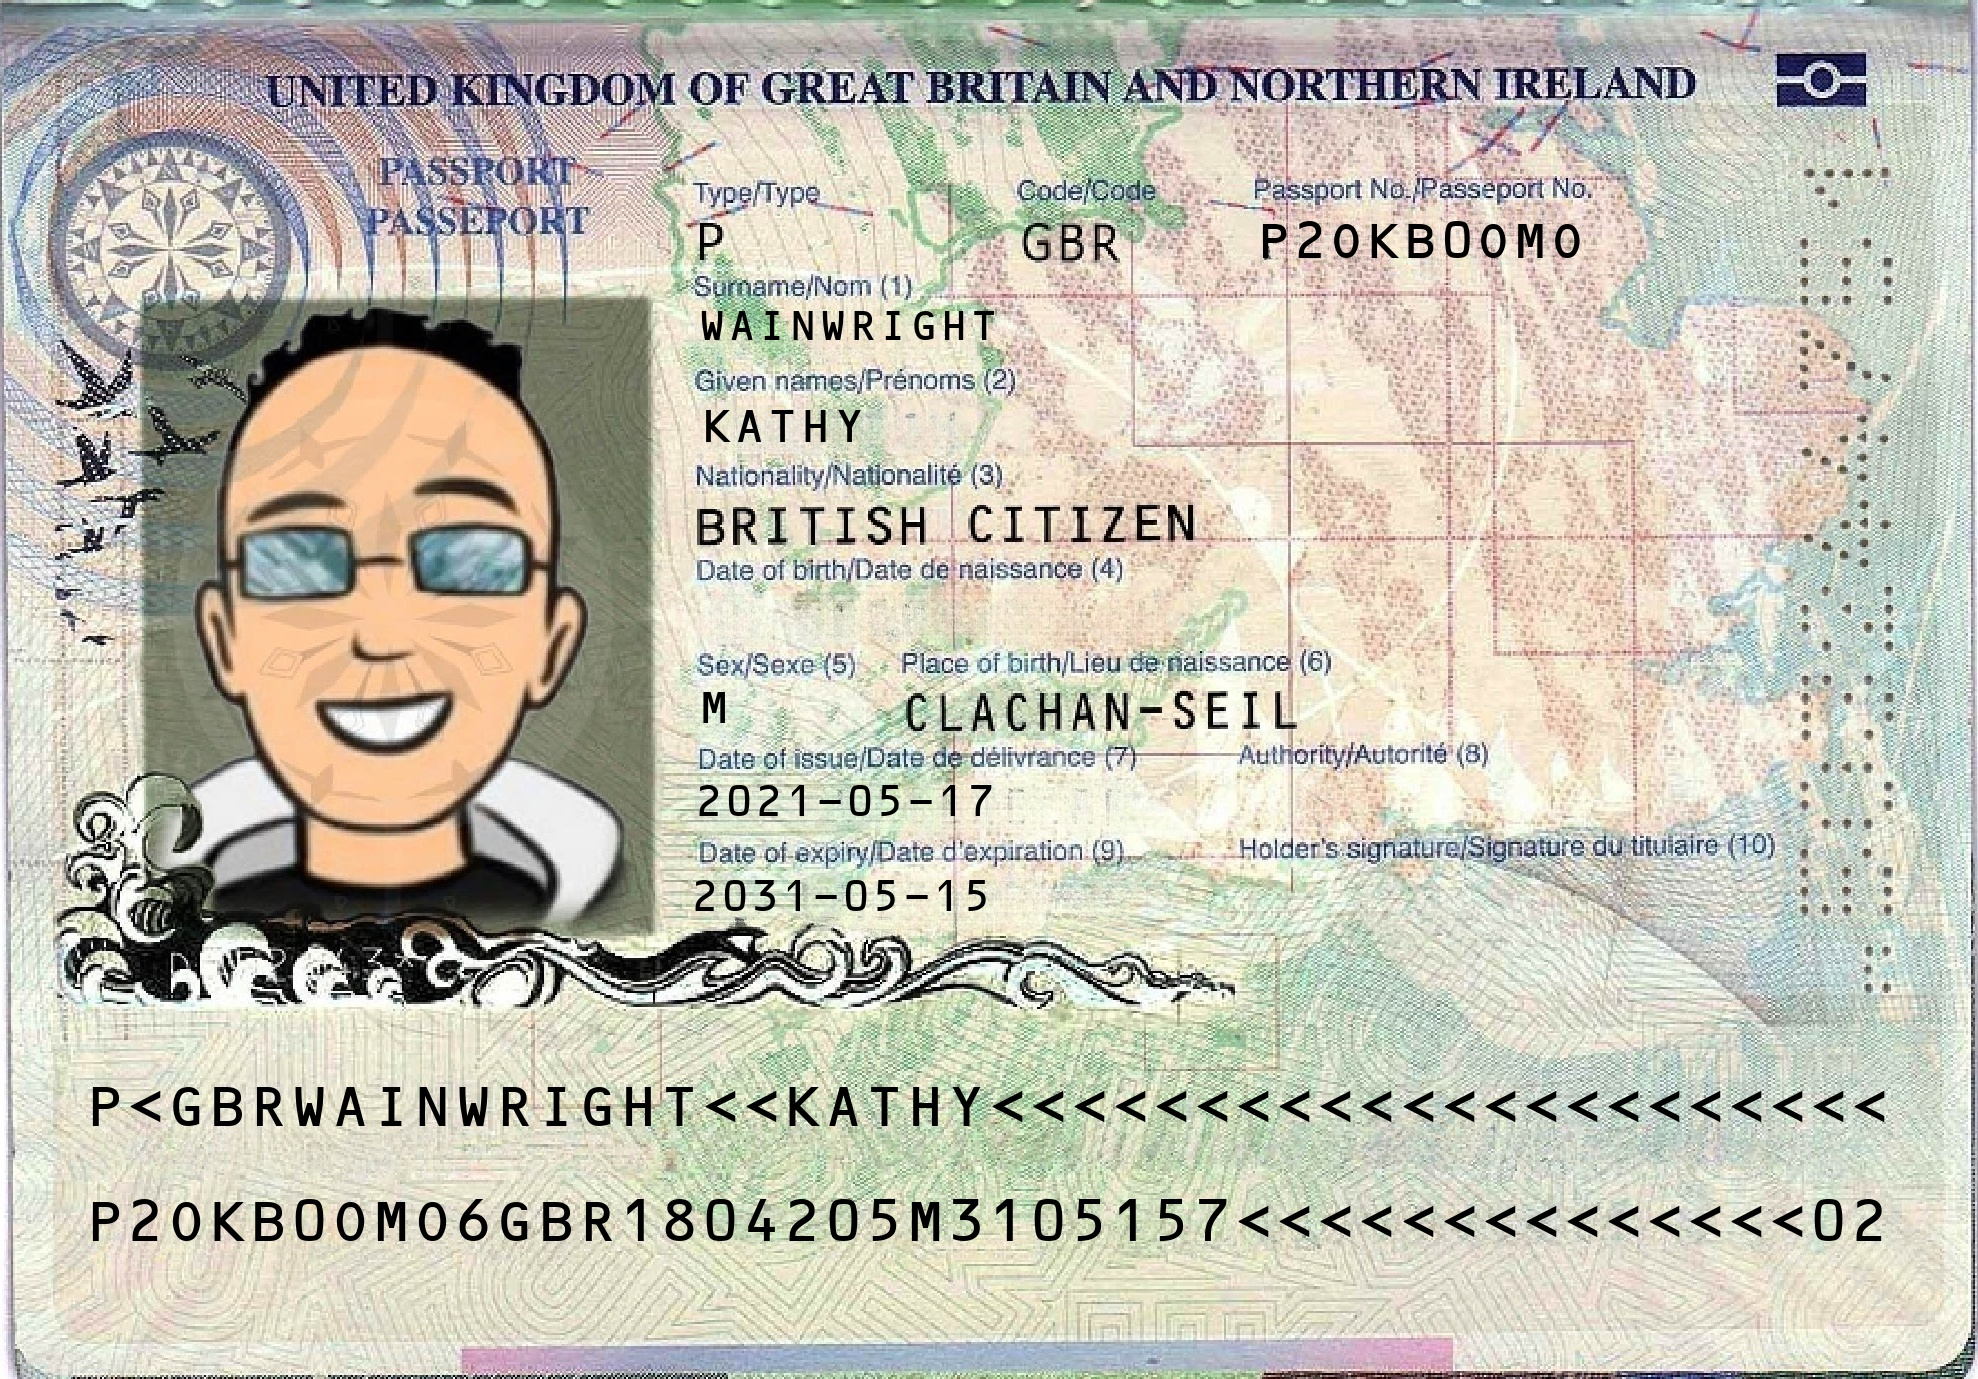

In [18]:
# проверим вручную
from PIL import Image
import torch

IMG = "/kaggle/input/country-detection/dataset/GBR/GBR_55.jpg"

img = Image.open(IMG).convert("RGB")
x = tf_eval(img).unsqueeze(0).to(DEVICE) 
with torch.no_grad():
    zi = model.encode_image(x)[0]
    scores = [(iso, float(torch.dot(zi, ce.to(DEVICE)))) for iso, ce in prototypes.iso2emb.items()]
    scores.sort(key=lambda t: t[1], reverse=True)
    topk = scores[:5]
    margin = topk[0][1] - topk[1][1] if len(topk) > 1 else float('nan')

print(f"Top-1: {topk[0][0]} ({topk[0][1]:.3f}), margin={margin:.3f}")
for iso, s in topk:
    print(f"{iso}: {s:.3f}")

display(img)


## 7. Плюсы и минусы <a id='end'></a>
**Сильные стороны**
- Масштабируется на множество стран;
- Обобщается на другие типы документов с помощью подсказок;
- Быстрый вывод.

**Слабые стороны**
- Схожие паспорта по дизайну, возможно, будут плохо определяться.
- Качество зависит от составления подсказок, приходится вручную вводить названия стран в пулл.
- Нужно больше данных, чтоб охватить как можно больше стран

**Как можно улучшить**
- Добавить больше примеров изображений и текстовых описаний.
- Попробовать другие эмбеддеры.